In [ ]:
!pip install beautifultable
!pip install bootstrapped

  Preparing metadata (setup.py) ... done
  Created wheel for bootstrapped: filename=bootstrapped-0.0.2-py2.py3-none-any.whl size=13932 sha256=16f52f55a8fe4a3771be065796c46408bd7f6735d1c10f03ab42001db315fe08
  Stored in directory: /root/.cache/pip/wheels/8b/47/d1/909397af2748ea916f6b72c346055e2426e7980bd1894b3633
Successfully built bootstrapped


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from beautifultable import BeautifulTable
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing
from beautifultable import BeautifulTable
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTE

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
directoryToRead = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
columnNames = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
featureNames = []

directoryName = 'AReM'
baseURL = '/content/drive/MyDrive/'

trainDataUpperBound = [7, 6, 15, 15, 15, 15, 15]
testDataUpperBound = [2, 2, 3, 3, 3, 3, 3]

In [ ]:
def readData(filePath):
    data = []

    with open(filePath, 'r') as inputFile:
        cnt = 1
        for line in inputFile:
            if cnt <= 5:
                cnt += 1
                continue
            columnData = line.split(',')
            if len(columnData) == 1:
                columnData = line.split()
            columnData = [x.strip() for x in columnData if x.strip()]
            columnData = list(map(float, columnData[1:]))  # Skip the timestamp
            data.append(columnData)

    data = pd.DataFrame(data, columns=columnNames)
    return data

In [ ]:
data = {}

for i in range(0, len(directoryToRead)):
    for j in range(1, trainDataUpperBound[i]+1):
        fileName = directoryName + '/' + directoryToRead[i] + '/dataset' + str(j) + '.csv'
        fileUrl = baseURL + fileName
        data[fileName] = readData(fileUrl)

In [ ]:
trainData = {}

for i in range(0, len(directoryToRead)):
    start = testDataUpperBound[i]+1
    end = trainDataUpperBound[i]
    for j in range(start, end+1):
        fileName = directoryName + '/' + directoryToRead[i] + '/dataset' + str(j) + '.csv'
        trainData[fileName] = data[fileName]

In [ ]:
testData = {}

for i in range(0, len(directoryToRead)):
    start = 1
    end = testDataUpperBound[i]
    for j in range(start, end+1):
        fileName = directoryName + '/' + directoryToRead[i] + '/dataset' + str(j) + '.csv'
        testData[fileName] = data[fileName]


In [ ]:
def getStatistics(data):
    statistics = data.describe()
    stats = {}
    stats['Mean'] = statistics[1:2].values[0].tolist()
    stats['Std'] = statistics[2:3].values[0].tolist()
    stats['Median'] = statistics[5:6].values[0].tolist()
    stats['Min'] = statistics[3:4].values[0].tolist()
    stats['Max'] = statistics[7:8].values[0].tolist()
    stats['FirstQuartile'] = statistics[4:5].values[0].tolist()
    stats['ThirdQuartile'] = statistics[6:7].values[0].tolist()
    return stats

# Print data in a tabular form
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(maxwidth=100)
    table.set_style(BeautifulTable.STYLE_SEPARATED)
    if len(tableHeaders)!=0:
        table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

In [ ]:
timeDomainData = []
for k,v in data.items():
    activity = k.split('/')[1]
    stats = getStatistics(v)
    means = stats['Mean']
    stds = stats['Std']
    medians = stats['Median']
    minValues = stats['Min']
    maxValues = stats['Max']
    firstQuartiles = stats['FirstQuartile']
    thirdQuartiles = stats['ThirdQuartile']

    if len(featureNames)==0:
        for i in range(0, len(columnNames)):
            featureNames.append('Min_' + columnNames[i])
            featureNames.append('Max_' + columnNames[i])
            featureNames.append('Mean_' + columnNames[i])
            featureNames.append('Median_' + columnNames[i])
            featureNames.append('Std_' + columnNames[i])
            featureNames.append('FirstQuartile_' + columnNames[i])
            featureNames.append('ThirdQuartile_' + columnNames[i])

    row = []
    for i in range(0, len(columnNames)):
        row.append(minValues[i])
        row.append(maxValues[i])
        row.append(means[i])
        row.append(medians[i])
        row.append(stds[i])
        row.append(firstQuartiles[i])
        row.append(thirdQuartiles[i])
    row.append(activity)
    timeDomainData.append(row)

timeDomainDataColumns = []
timeDomainDataColumns = featureNames[:]
timeDomainDataColumns.append('Activity')
timeDomainData = pd.DataFrame(timeDomainData, columns=timeDomainDataColumns)

print('--------------------------------------------------')
print('Total observations in time-domain feature data:', len(timeDomainData))
print('--------------------------------------------------')
print('Total features in time-domain feature data:', len(featureNames))
print('--------------------------------------------------')
print('First 5 observations in time-domain feature data:')
print('--------------------------------------------------')
print(timeDomainData[featureNames].head())

--------------------------------------------------
Total observations in time-domain feature data: 88
--------------------------------------------------
Total features in time-domain feature data: 42
--------------------------------------------------
First 5 observations in time-domain feature data:
--------------------------------------------------
   Min_avg_rss12  Max_avg_rss12  Mean_avg_rss12  Median_avg_rss12  \
0          37.25          45.00       40.624792             40.50   
1          38.00          45.67       42.812812             42.50   
2          35.00          47.40       43.954500             44.33   
3          33.00          47.75       42.179812             43.50   
4          33.00          45.75       41.678063             41.75   

   Std_avg_rss12  FirstQuartile_avg_rss12  ThirdQuartile_avg_rss12  \
0       1.476967                    39.25                    42.00   
1       1.435550                    42.00                    43.67   
2       1.558835       

In [ ]:
stats = timeDomainData[featureNames].describe()
stds = stats[2:3].values[0].tolist()
tableHeaders = ['Feature Name', 'Standard Deviation']
tableData = []
for i in range(0, len(featureNames)):
    row = []
    row.append(featureNames[i])
    row.append(stds[i])
    tableData.append(row)

print('STANDARD DEVIATION OF TIME-DOMAIN FEATURES:')
printDatainTable(tableHeaders, tableData)

STANDARD DEVIATION OF TIME-DOMAIN FEATURES:
+=========================+====================+
|      Feature Name       | Standard Deviation |
+=========================+====================+
|      Min_avg_rss12      |        9.57        |
+-------------------------+--------------------+
|      Max_avg_rss12      |       4.394        |
+-------------------------+--------------------+
|     Mean_avg_rss12      |       5.336        |
+-------------------------+--------------------+
|    Median_avg_rss12     |        5.44        |
+-------------------------+--------------------+
|      Std_avg_rss12      |       1.772        |
+-------------------------+--------------------+
| FirstQuartile_avg_rss12 |       6.154        |
+-------------------------+--------------------+
| ThirdQuartile_avg_rss12 |       5.139        |
+-------------------------+--------------------+
|      Min_var_rss12      |        0.0         |
+-------------------------+--------------------+
|      Max_var_rss12     

In [ ]:
tableData = []
for i in range(0, len(featureNames)):
    row = []
    samples = np.array(timeDomainData[featureNames[i]])
    bootResult = bs.bootstrap(samples, stat_func=bs_stats.std, alpha=0.1)
    row.append(featureNames[i])
    row.append(stds[i])
    row.append(bootResult.lower_bound)
    row.append(bootResult.upper_bound)
    tableData.append(row)

print('STANDARD DEVIATION & 90% CONFIDENCE INTERVAL OF TIME-DOMAIN FEATURES:')
tableHeader = ['Feature Name', 'Standard Deviation', 'Lower Bound', 'Upper Bound']
printDatainTable(tableHeader, tableData)

STANDARD DEVIATION & 90% CONFIDENCE INTERVAL OF TIME-DOMAIN FEATURES:
+=========================+====================+=============+=============+
|      Feature Name       | Standard Deviation | Lower Bound | Upper Bound |
+=========================+====================+=============+=============+
|      Min_avg_rss12      |        9.57        |    8.317    |   10.838    |
+-------------------------+--------------------+-------------+-------------+
|      Max_avg_rss12      |       4.394        |    3.462    |    5.431    |
+-------------------------+--------------------+-------------+-------------+
|     Mean_avg_rss12      |       5.336        |    4.769    |    5.936    |
+-------------------------+--------------------+-------------+-------------+
|    Median_avg_rss12     |        5.44        |    4.865    |    6.055    |
+-------------------------+--------------------+-------------+-------------+
|      Std_avg_rss12      |       1.772        |    1.583    |    1.961    |
+-----

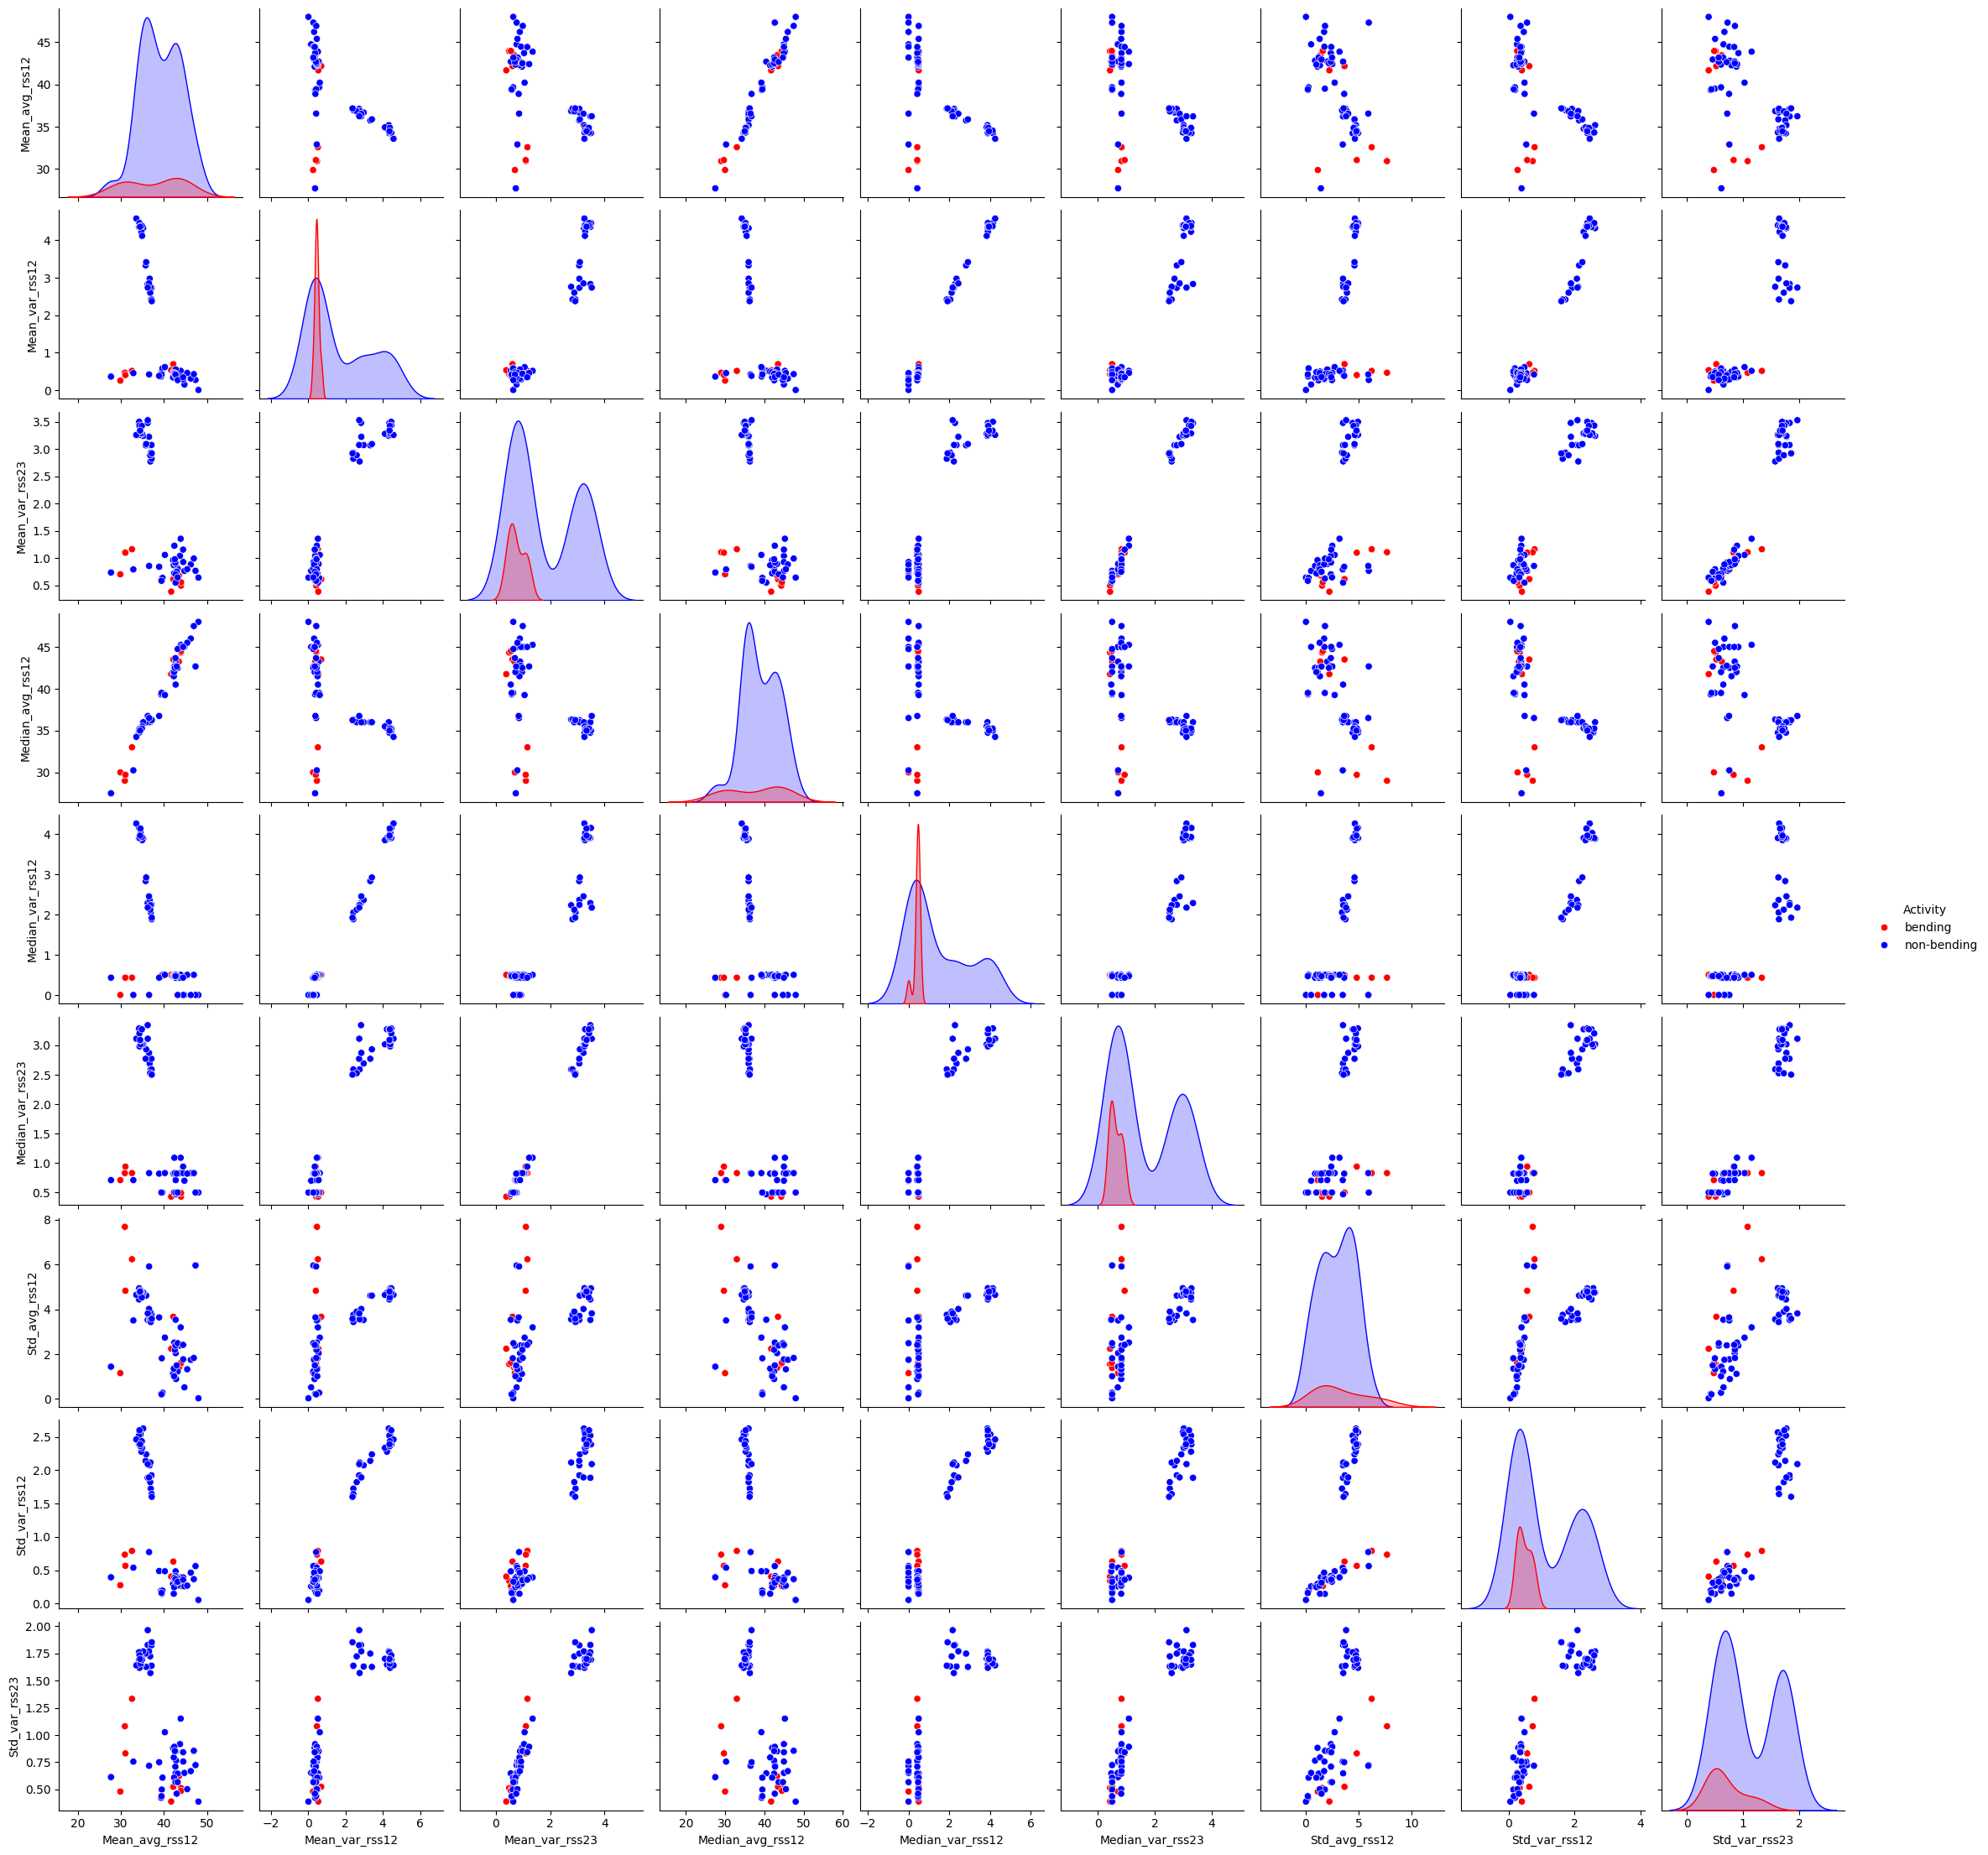

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 6]
featuresToPlot = []
trainDataDF = []

for k,v in trainData.items():
    activity = k.split('/')[1]
    stats = getStatistics(v)
    row = []
    for feature in selectedFeatures:
        dataFeaturesStats = stats[feature]
        for j in range(0, 6):
            if (j+1) in featuresToTake:
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake):
                    featuresToPlot.append(feature + '_' + columnNames[j])
                row.append(dataFeaturesStats[j])
    if activity=='bending1' or activity=='bending2':
        row.append('bending')
    else:
        row.append('non-bending')
    trainDataDF.append(row)

featuresToPlot.append('Activity')
trainDataDF = pd.DataFrame(trainDataDF, columns=featuresToPlot)

sns.pairplot(data=trainDataDF, hue='Activity', palette={'bending':'red','non-bending':'blue'})

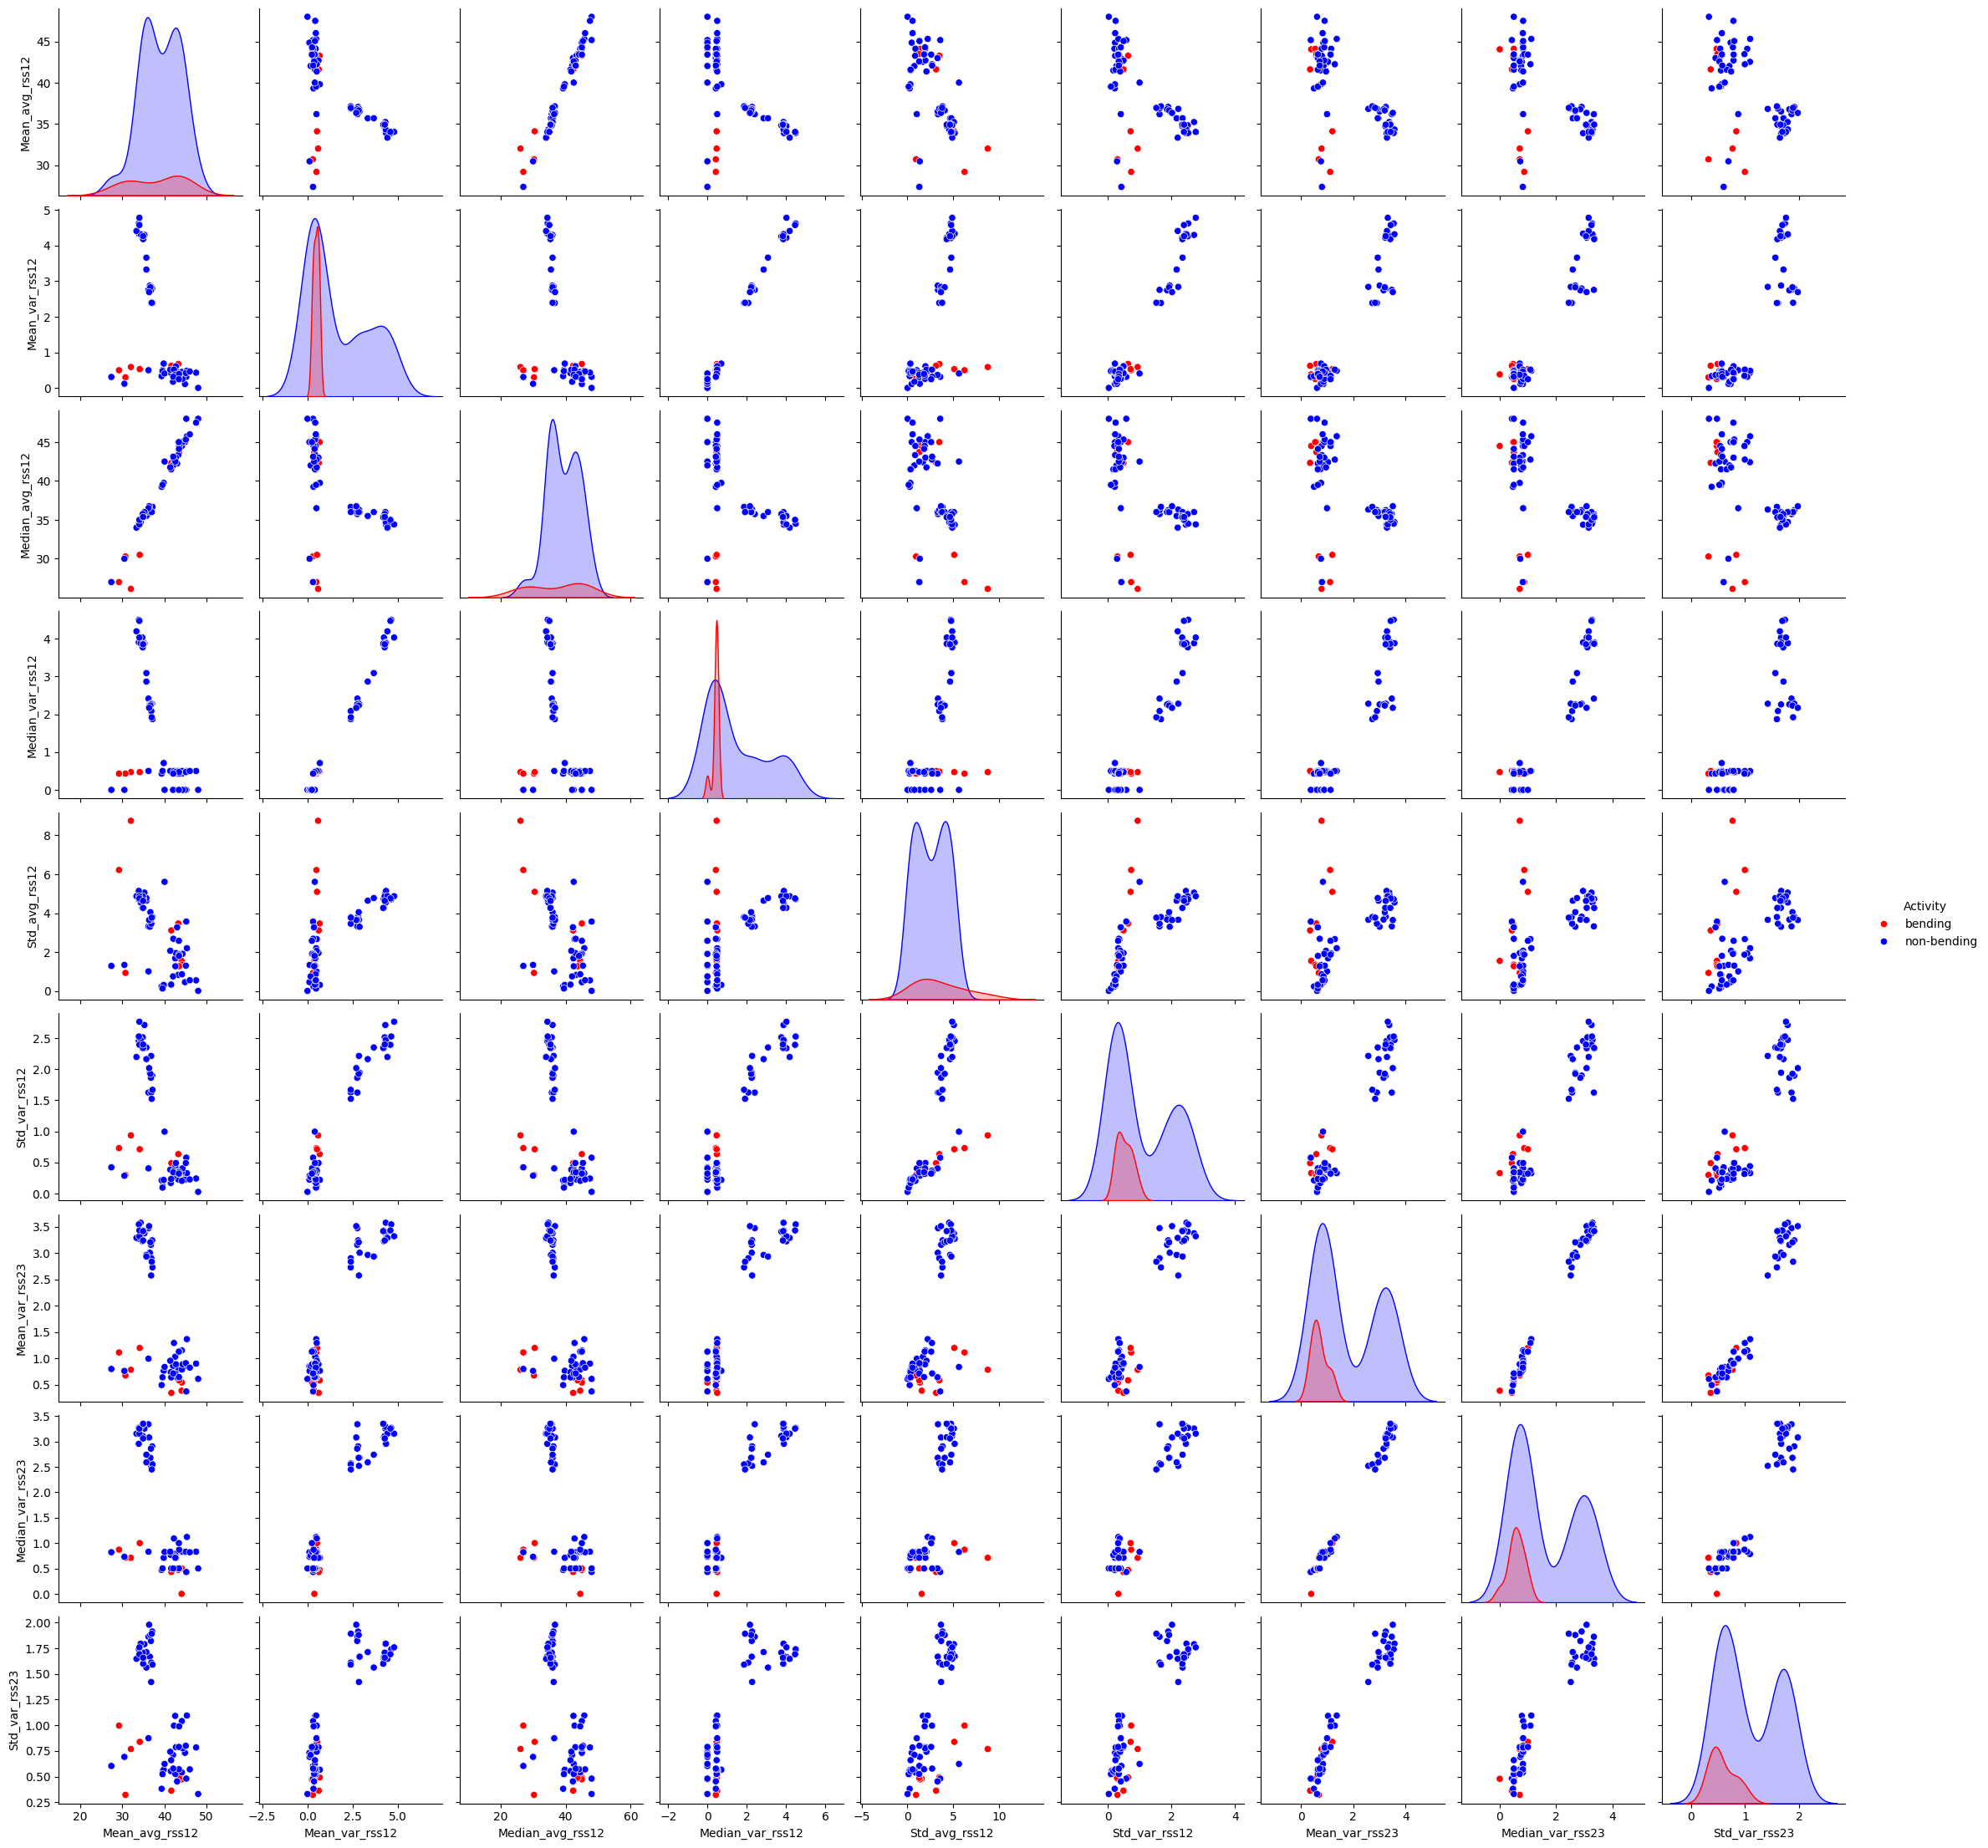

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 12]
featuresToPlot = []
trainDataDF = []

for k,v in trainData.items():
    cnt = 0
    activity = k.split('/')[1]
    splits = np.array_split(v, 2)
    row = []
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if (i+cnt+1) in featuresToTake:
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake):
                        featuresToPlot.append(feature + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])
        cnt += 6

    if activity=='bending1' or activity=='bending2':
        row.append('bending')
    else:
        row.append('non-bending')
    trainDataDF.append(row)

featuresToPlot.append('Activity')
trainDataDF = pd.DataFrame(trainDataDF, columns=featuresToPlot)

sns.pairplot(data=trainDataDF, hue='Activity', palette={'bending':'red','non-bending':'blue'})

After we break each time series into two equal-length time series, the scatterplot of both the classes (bending and non-bending) is more separable and easy to visualize.

Break each time series in training data into L={1,2,...20} time series and fit logistic regression to find best L and best features.



In [ ]:
import sys

selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

LRTableData = []
bestFeaturesL = {}
trainDataL = {}
for L in range(1, 21):
    featuresToPlot = []
    trainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])

            splitNum += 1

        if activity=='bending1' or activity=='bending2':
            row.append(1)
        else:
            row.append(0)
        trainDataDF.append(row)

    featuresToPlot.append('Activity')
    trainDataDF = pd.DataFrame(trainDataDF, columns=featuresToPlot)

    accuracy = []
    areaUnderCurve = []
    foldFeatures = []
    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    for trainIdx, valIdx in stratifiedKFolds.split(trainDataDF[featuresToPlot], trainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(trainDataDF[featuresToPlot].iloc[idx])
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)

        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(trainDataDF[featuresToPlot].iloc[idx])
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)

        # Select best predictors
        logRegModel1 = LogisticRegression(solver='liblinear', C=sys.maxsize)
        rfecvModel = RFECV(estimator=logRegModel1, cv=StratifiedKFold(5))
        rfecvModel.fit(trainX, trainY)
        ranking = rfecvModel.ranking_
        bestFeatures = []
        for i in range(0, len(ranking)):
            if ranking[i]==1:
                bestFeatures.append(featuresToPlot[i])

        newTrainX = trainX.loc[:,bestFeatures]
        newValX = valX.loc[:,bestFeatures]

        # Retrain logistic regression with best predictors
        logRegModel2 = LogisticRegression(solver='liblinear', C=sys.maxsize)
        logRegModel2 = logRegModel2.fit(newTrainX, trainY)

        # Find accuracy on cross-validation data
        validationAccuracy = logRegModel2.score(newValX, valY)
        validationPredictedYProb = logRegModel2.predict_proba(newValX)[::,1]
        validationAUC = roc_auc_score(valY, validationPredictedYProb)

        accuracy.append(validationAccuracy)
        areaUnderCurve.append(validationAUC)
        foldFeatures.append(bestFeatures)

    row = []
    row.append(L)
    row.append(np.mean(accuracy))
    row.append(np.mean(areaUnderCurve))
    kFoldIdx = np.argmax(areaUnderCurve)
    bestFeaturesL[L] = foldFeatures[kFoldIdx]
    trainDataL[L] = trainDataDF

    LRTableData.append(row)


tableHeaders = ['L', 'Accuracy', 'Area Under Curve']
printDatainTable(tableHeaders, LRTableData)

+====+==========+==================+
| L  | Accuracy | Area Under Curve |
+====+==========+==================+
| 1  |  0.942   |      0.983       |
+----+----------+------------------+
| 2  |  0.899   |      0.975       |
+----+----------+------------------+
| 3  |  0.929   |      0.983       |
+----+----------+------------------+
| 4  |   0.9    |      0.975       |
+----+----------+------------------+
| 5  |  0.943   |       0.95       |
+----+----------+------------------+
| 6  |   0.9    |      0.917       |
+----+----------+------------------+
| 7  |   0.9    |      0.933       |
+----+----------+------------------+
| 8  |  0.929   |      0.983       |
+----+----------+------------------+
| 9  |  0.943   |       1.0        |
+----+----------+------------------+
| 10 |  0.943   |      0.867       |
+----+----------+------------------+
| 11 |  0.943   |      0.992       |
+----+----------+------------------+
| 12 |  0.929   |      0.933       |
+----+----------+------------------+
|

In [ ]:
maxLRAUC = LRTableData[0][2]
LRBestL = 1
for i in range(1, len(LRTableData)):
    if LRTableData[i][2]>maxLRAUC:
        maxLRAUC = LRTableData[i][2]
        LRBestL = LRTableData[i][0]

bestSelectedFeatures = bestFeaturesL[LRBestL]
print('------------------------------------------------------------------')
print('BEST L based on AUC:', LRBestL)
print('------------------------------------------------------------------')

print('BEST FEATURES:')
tableData = []
for i in range(0, len(bestSelectedFeatures)):
    row = []
    row.append(bestSelectedFeatures[i])
    tableData.append(row)

tableHeaders = ['Feature Name']
printDatainTable(tableHeaders, tableData)

------------------------------------------------------------------
BEST L based on AUC: 9
------------------------------------------------------------------
BEST FEATURES:
+=========================+
|      Feature Name       |
+=========================+
|  Mean_Split3_avg_rss23  |
+-------------------------+
| Median_Split7_avg_rss12 |
+-------------------------+


The right way to perform cross-validation involves conducting preprocessing feature selection, and hyperparameter tuning within each fold to avoid information leakage. This ensures that the model's performance is evaluated fairly without overfitting to the validation data.

Wrong way - Pre processing and Feature Selection Outside Cross-Validation Loop. Causes overfitting because feature selection is performed on the entire dataset, allowing the validation set to influence which features are selected.

I have preferred Area Under Curve (AUC) over Accuracy to find out the best (L, P) pair because AUC is insensitive to imbalanced classes.

Report confusion matrix, ROC, AUC, Coefficients and p-values of final logistic regression model:

In [ ]:
newTrainX = trainDataL[LRBestL][bestSelectedFeatures]
newTrainY = trainDataL[LRBestL]['Activity']

# Refit Logistic Regression on best (L, P) pair
logRegModel = LogisticRegression(solver='liblinear', C=sys.maxsize)
logRegModel = logRegModel.fit(newTrainX, newTrainY)

# coefficients
coefficients = logRegModel.coef_[0]

# p-values
_, pValues = chi2(newTrainX, newTrainY)

for i in range(0, len(pValues)):
    pValues[i] = round(pValues[i], 3)
    coefficients[i] = round(coefficients[i], 3)

tableData = []
for i in range(0, len(bestSelectedFeatures)):
    row = []
    row.append(bestSelectedFeatures[i])
    row.append(coefficients[i])
    row.append(pValues[i])
    tableData.append(row)

tableHeaders = ['Feature Name', 'Coefficient', 'p-value']
print('COEFFICIENT & P-VALUE FOR BEST FEATURES:')
printDatainTable(tableHeaders, tableData)

COEFFICIENT & P-VALUE FOR BEST FEATURES:
+=========================+=============+=========+
|      Feature Name       | Coefficient | p-value |
+=========================+=============+=========+
|  Mean_Split3_avg_rss23  |    17.23    |   0.0   |
+-------------------------+-------------+---------+
| Median_Split7_avg_rss12 |   -8.012    |  0.205  |
+-------------------------+-------------+---------+


In [ ]:
def printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive):
    tableData = []
    row1 = []
    row1.append('')
    row1.append('Predicted Bending')
    row1.append('Predicted Non-Bending')
    tableData.append(row1)

    row2 = []
    row2.append('Actual Bending')
    row2.append(truePositive)
    row2.append(falseNegative)
    tableData.append(row2)

    row3 = []
    row3.append('Actual Non-Bending')
    row3.append(falsePositive)
    row3.append(trueNegative)
    tableData.append(row3)

    printDatainTable([], tableData)

CONFUSION MATRIX FOR TRAINING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         9         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         0         |          60           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
1.0
------------------------------------------------------------------
AREA UNDER CURVE FOR TRAINING DATA:
1.0
------------------------------------------------------------------
ROC FOR TRAINING DATA:


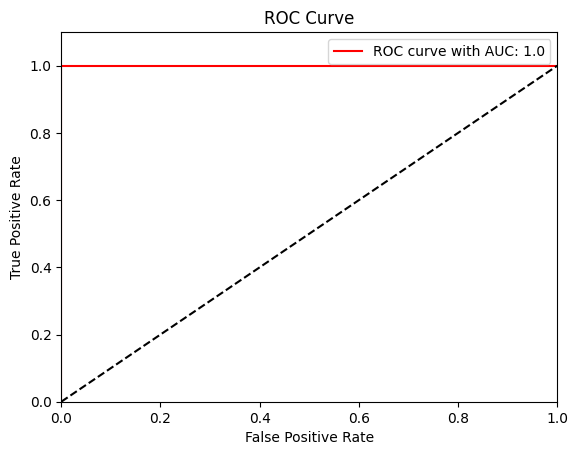

In [ ]:
# predictions on training data
predictedY = logRegModel.predict(newTrainX)


# Confusion Matrix
print('CONFUSION MATRIX FOR TRAINING DATA:')
LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive = confusion_matrix(newTrainY, predictedY).ravel()
printConfusionMatrix(LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive)
print('------------------------------------------------------------------')


# Accuracy on training data
LRTrainAccuracy = logRegModel.score(newTrainX, newTrainY)
LRTrainAccuracy = round(LRTrainAccuracy, 3)
print('ACCURACY FOR TRAINING DATA:')
print(LRTrainAccuracy)
print('------------------------------------------------------------------')


# AUC value on training data
predictedYProb = logRegModel.predict_proba(newTrainX)[::,1]
LRfpr, LRtpr, _ = roc_curve(newTrainY,  predictedYProb)
LRTrainAUC = roc_auc_score(newTrainY, predictedYProb)
LRTrainAUC = round(LRTrainAUC, 3)
print('AREA UNDER CURVE FOR TRAINING DATA:')
print(LRTrainAUC)
print('------------------------------------------------------------------')


# ROC curve
print('ROC FOR TRAINING DATA:')
plt.plot(LRfpr, LRtpr, color='red', label='ROC curve with AUC: ' + str(LRTrainAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

Compare accuracy of logistic regression model on testing data and cross-validation data:

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
LRTestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, LRBestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*LRBestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])

        splitNum += 1

    if activity=='bending1' or activity=='bending2':
        row.append(1)
    else:
        row.append(0)
    LRTestDataDF.append(row)

featuresToPlot.append('Activity')
LRTestDataDF = pd.DataFrame(LRTestDataDF, columns=featuresToPlot)
LRTestDataX = LRTestDataDF[bestSelectedFeatures]
LRTestDataY = LRTestDataDF['Activity']

# Accuracy on test data
LRTestAccuracy = logRegModel.score(LRTestDataX, LRTestDataY)
LRTestAccuracy = round(LRTestAccuracy, 3)

# Cross-validation Accuracy
LRValidationAccuracy = 0
for i in range(0, len(LRTableData)):
    if LRTableData[i][0]==LRBestL:
        LRValidationAccuracy = round(LRTableData[i][1], 3)
        break

tableData = []
row = []
row.append(LRBestL)
row.append(LRTestAccuracy)
row.append(LRValidationAccuracy)
tableData.append(row)
tableHeaders = ['Best L', 'Testing Accuracy', 'Cross-Validation Accuracy']
printDatainTable(tableHeaders, tableData)

+========+==================+===========================+
| Best L | Testing Accuracy | Cross-Validation Accuracy |
+========+==================+===========================+
|   9    |      0.895       |           0.943           |
+--------+------------------+---------------------------+


The test accuracy is around 90%, so the model is performing well on test data.

Analysis: The classes (bending and non-bending) are not well separated. So, when we use K-fold Cross Validation, there is a possiblity that some folds may not get any samples from the minority class. So, to solve this problem, Stratified K-fold Cross Validation has been used to take care of class imbalance. Also, Stratified K-fold Cross Validation has reduced the instability in calculating the logistic regression parameters.

From the confusion matrices you obtained, do you see imbalanced classes? :

CONFUSION MATRIX FOR TESTING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         4         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         2         |          13           |
+--------------------+-------------------+-----------------------+
AREA UNDER CURVE FOR TESTING DATA:
1.0
------------------------------------------------------------------
ROC FOR TESTING DATA:


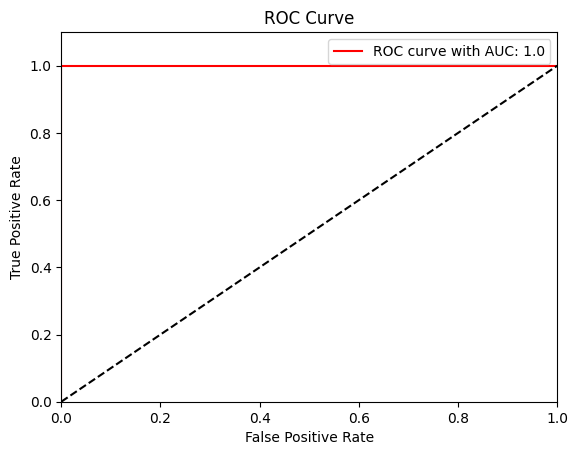

In [ ]:
# predictions on testing data
predictedY = logRegModel.predict(LRTestDataX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TESTING DATA:')
LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive = confusion_matrix(LRTestDataY, predictedY).ravel()
printConfusionMatrix(LRTrueNegative, LRFalsePositive, LRFalseNegative, LRTruePositive)

# AUC value on training data
predictedYProb = logRegModel.predict_proba(LRTestDataX)[::,1]
LRfpr, LRtpr, _ = roc_curve(LRTestDataY,  predictedYProb)
LRTestAUC = round(roc_auc_score(LRTestDataY, predictedYProb), 3)
print('AREA UNDER CURVE FOR TESTING DATA:')
print(LRTestAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TESTING DATA:')
plt.plot(LRfpr, LRtpr, color='red', label='ROC curve with AUC: ' + str(LRTestAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

Yes, the classes (bending and non-bending) are imbalanced. There are only 4 samples of bending class, as compared to 15 samples of non-bending class in test data.

In [ ]:
def multiClassROC(model, trainDataY, testDataX, testDataY, return_plot=True):
    lb = preprocessing.LabelBinarizer()
    lb.fit(trainDataY)
    trainDataY = lb.transform(trainDataY)
    testDataY = lb.transform(testDataY)

    predictedProbY = model.predict_proba(testDataX)

    fpr = {}
    tpr = {}
    roc_auc = {}

    fig, ax = plt.subplots(figsize=(8, 6))

    for i in range(0, 7):
        fpr[i], tpr[i], _ = roc_curve(testDataY[:, i], predictedProbY[:, i])
        roc_auc[i] = round(auc(fpr[i], tpr[i]), 2)
        className = directoryToRead[i]
        label = f'ROC of {className} AUC: {roc_auc[i]}'
        ax.plot(fpr[i], tpr[i], label=label)

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve - Multiclass')
    ax.legend()

    if return_plot:
        return fig, roc_auc
    else:
        plt.show()
        return None

def getMultiClassPredictions(classModels, trainDataX):
    predictions = []
    PredictionProbability = pd.DataFrame()
    for j in range(0, len(classModels)):
        classModel = classModels[j]
        predProb = classModel.predict_proba(trainDataX)
        predProbClass = []
        for i in range(0, len(predProb)):
            predProbClass.append(round(predProb[i][1], 3))
        predProbClass = pd.DataFrame(predProbClass, columns=[directoryToRead[j]])
        PredictionProbability = pd.concat([PredictionProbability, predProbClass], axis=1)

    for i in range(0, len(PredictionProbability)):
        maxProb = 0.0
        predClass = ''
        for j in range(0, len(directoryToRead)):
            prob = PredictionProbability[directoryToRead[j]][i]
            if prob>maxProb:
                maxProb = prob
                predClass = directoryToRead[j]
        predictions.append(directoryToRead.index(predClass))

    return predictions, PredictionProbability

Logistic Regression model based on case-control sampling and report the confusion matrix, ROC, and AUC of the model:

In [ ]:
newTrainX = trainDataL[LRBestL][bestSelectedFeatures]
newTrainY = trainDataL[LRBestL]['Activity']

nonBCnt = 0
bCnt = 0
for i in range(0, len(newTrainY)):
    if newTrainY[i]==0:
        nonBCnt += 1
    else:
        bCnt += 1

print('------------------------------------------------------------------')
print('Before Over-sampling, number of bending observations:', bCnt)
print('Before Over-sampling, number of non-bending observations:', nonBCnt)
print('------------------------------------------------------------------')

sm = SMOTE(sampling_strategy='all')
sampledTrainX, sampledTrainY = sm.fit_resample(newTrainX, newTrainY.ravel())

sampledNonBCnt = 0
sampledBCnt = 0
for i in range(0, len(sampledTrainY)):
    if sampledTrainY[i]==0:
        sampledNonBCnt += 1
    else:
        sampledBCnt += 1

print('------------------------------------------------------------------')
print('After Over-sampling, number of bending observations:', sampledBCnt)
print('After Over-sampling, number of non-bending observations:', sampledNonBCnt)
print('------------------------------------------------------------------')

------------------------------------------------------------------
Before Over-sampling, number of bending observations: 9
Before Over-sampling, number of non-bending observations: 60
------------------------------------------------------------------
------------------------------------------------------------------
After Over-sampling, number of bending observations: 60
After Over-sampling, number of non-bending observations: 60
------------------------------------------------------------------


------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
1.0
------------------------------------------------------------------
CONFUSION MATRIX FOR TRAINING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |        60         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         0         |          60           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
AREA UNDER CURVE FOR TRAINING DATA:
1.0
------------------------------------------------------------------
ROC FOR TRAINING DATA:


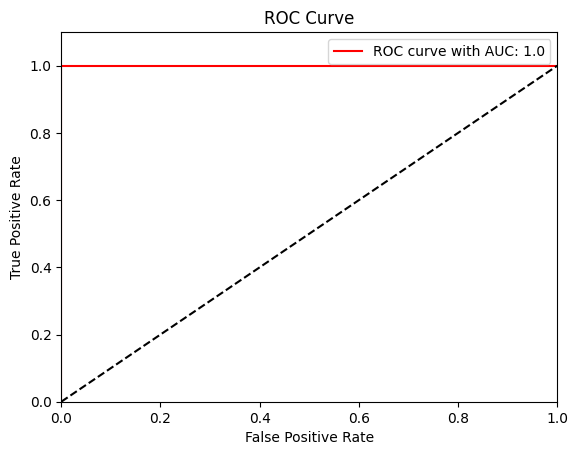

In [ ]:
logRegBalancedModel = LogisticRegression(solver='liblinear', C=sys.maxsize)
logRegBalancedModel = logRegBalancedModel.fit(sampledTrainX, sampledTrainY)

# Accuracy on train data
LRBalancedTrainAccuracy = logRegBalancedModel.score(sampledTrainX, sampledTrainY)
LRBalancedTrainAccuracy = round(LRBalancedTrainAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA:')
print(LRBalancedTrainAccuracy)
print('------------------------------------------------------------------')

# predictions on testing data
predictedTrainY = logRegBalancedModel.predict(sampledTrainX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TRAINING DATA:')
trueNegative, falsePositive, falseNegative, truePositive = confusion_matrix(sampledTrainY, predictedTrainY).ravel()
printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive)
print('------------------------------------------------------------------')

predictedTrainYProb = logRegBalancedModel.predict_proba(sampledTrainX)[::,1]
fpr, tpr, _ = roc_curve(sampledTrainY,  predictedTrainYProb)
LRBalancedTrainAUC = round(roc_auc_score(sampledTrainY, predictedTrainYProb), 3)

# AUC value
print('AREA UNDER CURVE FOR TRAINING DATA:')
print(LRBalancedTrainAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TRAINING DATA:')
plt.plot(fpr, tpr, color='red', label='ROC curve with AUC: ' + str(LRBalancedTrainAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

------------------------------------------------------------------
ACCURACY FOR TESTING DATA:
0.895
------------------------------------------------------------------
CONFUSION MATRIX FOR TESTING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         4         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         2         |          13           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
AREA UNDER CURVE FOR TESTING DATA:
1.0
------------------------------------------------------------------
ROC FOR TESTING DATA:


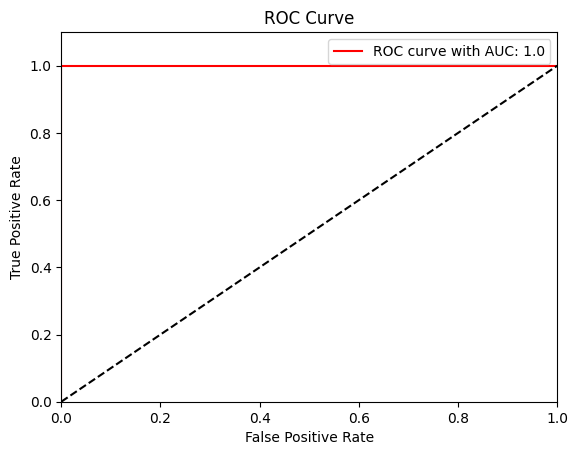

In [ ]:
# Accuracy on test data
LRBalancedTestAccuracy = logRegBalancedModel.score(LRTestDataX, LRTestDataY)
LRBalancedTestAccuracy = round(LRBalancedTestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA:')
print(LRBalancedTestAccuracy)
print('------------------------------------------------------------------')

# predictions on testing data
predictedY = logRegBalancedModel.predict(LRTestDataX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TESTING DATA:')
trueNegative, falsePositive, falseNegative, truePositive = confusion_matrix(LRTestDataY, predictedY).ravel()
printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive)
print('------------------------------------------------------------------')

predictedYProb = logRegBalancedModel.predict_proba(LRTestDataX)[::,1]
fpr, tpr, _ = roc_curve(LRTestDataY,  predictedYProb)
LRBalancedAUC = round(roc_auc_score(LRTestDataY, predictedYProb), 3)

# AUC value
print('AREA UNDER CURVE FOR TESTING DATA:')
print(LRBalancedAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TESTING DATA:')
plt.plot(fpr, tpr, color='red', label='ROC curve with AUC: ' + str(LRBalancedAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

L1PenalizedData = []
L1PenalizedTrainData = {}
l1LambdaL = {}
for L in range(1, 21):
    featuresToPlot = []
    L1TrainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])

            splitNum += 1

        if activity=='bending1' or activity=='bending2':
            row.append(1)
        else:
            row.append(0)
        L1TrainDataDF.append(row)

    featuresToPlot.append('Activity')
    L1TrainDataDF = pd.DataFrame(L1TrainDataDF, columns=featuresToPlot)

    # normalize data
    norm1 = preprocessing.MinMaxScaler()
    norm = norm1.fit_transform(L1TrainDataDF.values)
    L1TrainDataDF = pd.DataFrame(norm, columns=L1TrainDataDF.columns)

    accuracy = []
    areaUnderCurve = []
    l1Lambda = []
    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    for trainIdx, valIdx in stratifiedKFolds.split(L1TrainDataDF[featuresToPlot], L1TrainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(L1TrainDataDF[featuresToPlot].iloc[idx])
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)

        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(L1TrainDataDF[featuresToPlot].iloc[idx])
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)

        # Fit regularized logistic regression
        L1LogRegModel = LogisticRegressionCV(cv=5, solver='liblinear', penalty='l1', max_iter=1000)
        L1LogRegModel = L1LogRegModel.fit(trainX, trainY)
        penalty = L1LogRegModel.C_[0]
        lambdaVal = round(float(1/penalty), 3)

        # Cross-validation accuracy and auc
        L1ValidationAccuracy = L1LogRegModel.score(valX, valY)
        predictedYProb = L1LogRegModel.predict_proba(valX)[::,1]
        fpr, tpr, _ = roc_curve(valY,  predictedYProb)
        L1ValidationAUC = roc_auc_score(valY, predictedYProb)

        accuracy.append(L1ValidationAccuracy)
        areaUnderCurve.append(L1ValidationAUC)
        l1Lambda.append(lambdaVal)

    row = []
    row.append(L)
    row.append(np.mean(accuracy))
    row.append(np.mean(areaUnderCurve))
    kFoldIdx = np.argmax(areaUnderCurve)
    l1LambdaL[L] = l1Lambda[kFoldIdx]
    trainDataL[L] = trainDataDF

    L1PenalizedData.append(row)
    L1PenalizedTrainData[L] = L1TrainDataDF

tableHeaders = ['L', 'Accuracy', 'AUC']
printDatainTable(tableHeaders, L1PenalizedData)

+====+==========+=======+
| L  | Accuracy |  AUC  |
+====+==========+=======+
| 1  |   0.87   | 0.95  |
+----+----------+-------+
| 2  |  0.929   | 0.925 |
+----+----------+-------+
| 3  |  0.929   | 0.975 |
+----+----------+-------+
| 4  |  0.943   | 0.992 |
+----+----------+-------+
| 5  |  0.885   | 0.967 |
+----+----------+-------+
| 6  |  0.914   | 0.942 |
+----+----------+-------+
| 7  |  0.927   | 0.992 |
+----+----------+-------+
| 8  |  0.913   | 0.942 |
+----+----------+-------+
| 9  |  0.913   | 0.925 |
+----+----------+-------+
| 10 |  0.913   | 0.958 |
+----+----------+-------+
| 11 |  0.899   | 0.867 |
+----+----------+-------+
| 12 |  0.899   | 0.892 |
+----+----------+-------+
| 13 |  0.885   | 0.933 |
+----+----------+-------+
| 14 |  0.913   | 0.842 |
+----+----------+-------+
| 15 |  0.927   | 0.942 |
+----+----------+-------+
| 16 |  0.899   | 0.908 |
+----+----------+-------+
| 17 |  0.913   | 0.908 |
+----+----------+-------+
| 18 |  0.914   | 0.95  |
+----+------

In [ ]:
L1MaxAUC = L1PenalizedData[0][2]
L1BestL = L1PenalizedData[0][0]
bestLambda = L1PenalizedData[0][1]
for i in range(0, len(L1PenalizedData)):
    if L1PenalizedData[i][2]>L1MaxAUC:
        L1MaxAUC = L1PenalizedData[i][2]
        L1BestL = L1PenalizedData[i][0]

bestLambda = l1Lambda[L1BestL]

print('------------------------------------------------------------------')
print('BEST L based on AUC:', L1BestL)
print('------------------------------------------------------------------')

print('Best Lambda:', bestLambda)
print('------------------------------------------------------------------')

------------------------------------------------------------------
BEST L based on AUC: 4
------------------------------------------------------------------
Best Lambda: 0.046
------------------------------------------------------------------


------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
1.0
------------------------------------------------------------------
CONFUSION MATRIX FOR TRAINING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         9         |           0           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         0         |          60           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
AREA UNDER CURVE FOR TRAINING DATA:
1.0
------------------------------------------------------------------
ROC FOR TRAINING DATA:


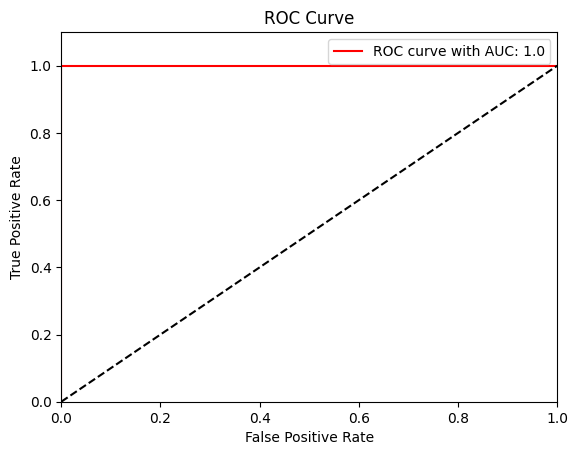

In [ ]:
L1TrainDataDF = L1PenalizedTrainData[L1BestL]
L1TrainDataY = pd.DataFrame(L1TrainDataDF['Activity'])
L1TrainDataX = L1TrainDataDF.drop('Activity', axis=1)

L1TrainDataY = np.array(L1TrainDataY).flatten()

bestCVal = round(float(1/bestLambda), 3)
L1Model = LogisticRegression(solver='liblinear', penalty='l1', C=bestCVal)
L1Model = L1Model.fit(L1TrainDataX, L1TrainDataY)

L1TrainAccuracy = L1Model.score(L1TrainDataX, L1TrainDataY)
L1TrainAccuracy = round(L1TrainAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA:')
print(L1TrainAccuracy)
print('------------------------------------------------------------------')

# predictions on training data
L1PredictedY = L1Model.predict(L1TrainDataX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TRAINING DATA:')
L1TrueNegative, L1FalsePositive, L1FalseNegative, L1TruePositive = confusion_matrix(L1TrainDataY, L1PredictedY).ravel()
printConfusionMatrix(L1TrueNegative, L1FalsePositive, L1FalseNegative, L1TruePositive)
print('------------------------------------------------------------------')

L1PredictedYProb = L1Model.predict_proba(L1TrainDataX)[::,1]
L1fpr, L1tpr, _ = roc_curve(L1TrainDataY,  L1PredictedYProb)
L1TrainAUC = round(roc_auc_score(L1TrainDataY, L1PredictedYProb), 3)

# AUC value
print('AREA UNDER CURVE FOR TRAINING DATA:')
print(L1TrainAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TRAINING DATA:')
plt.plot(L1fpr, L1tpr, color='red', label='ROC curve with AUC: ' + str(L1TrainAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

------------------------------------------------------------------
ACCURACY FOR TESTING DATA:
0.947
------------------------------------------------------------------
CONFUSION MATRIX FOR TESTING DATA:
+====================+===================+=======================+
|                    | Predicted Bending | Predicted Non-Bending |
+--------------------+-------------------+-----------------------+
|   Actual Bending   |         3         |           1           |
+--------------------+-------------------+-----------------------+
| Actual Non-Bending |         0         |          15           |
+--------------------+-------------------+-----------------------+
------------------------------------------------------------------
AREA UNDER CURVE FOR TESTING DATA:
0.967
------------------------------------------------------------------
ROC FOR TESTING DATA:


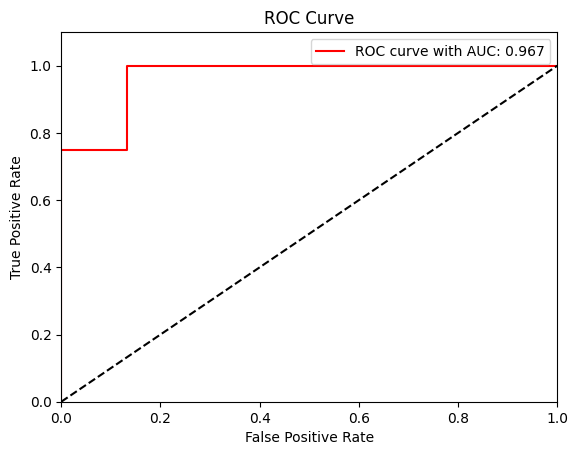

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
L1TestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, L1BestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L1BestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])

        splitNum += 1

    if activity=='bending1' or activity=='bending2':
        row.append(1)
    else:
        row.append(0)
    L1TestDataDF.append(row)

featuresToPlot.append('Activity')
L1TestDataDF = pd.DataFrame(L1TestDataDF, columns=featuresToPlot)

# normalize data
norm1 = preprocessing.MinMaxScaler()
norm = norm1.fit_transform(L1TestDataDF.values)
L1TestDataDF = pd.DataFrame(norm, columns=L1TestDataDF.columns)

L1TestDataY = pd.DataFrame(L1TestDataDF['Activity'])
L1TestDataX = L1TestDataDF.drop('Activity', axis=1)

L1TestAccuracy = L1Model.score(L1TestDataX, L1TestDataY)
L1TestAccuracy = round(L1TestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA:')
print(L1TestAccuracy)
print('------------------------------------------------------------------')

# predictions on testing data
L1PredictedY = L1Model.predict(L1TestDataX)

# Confusion Matrix
print('CONFUSION MATRIX FOR TESTING DATA:')
L1TrueNegative, L1FalsePositive, L1FalseNegative, L1TruePositive = confusion_matrix(L1TestDataY, L1PredictedY).ravel()
printConfusionMatrix(L1TrueNegative, L1FalsePositive, L1FalseNegative, L1TruePositive)
print('------------------------------------------------------------------')

L1PredictedYProb = L1Model.predict_proba(L1TestDataX)[::,1]
L1fpr, L1tpr, _ = roc_curve(L1TestDataY,  L1PredictedYProb)
L1TestAUC = round(roc_auc_score(L1TestDataY, L1PredictedYProb), 3)

# AUC value
print('AREA UNDER CURVE FOR TESTING DATA:')
print(L1TestAUC)
print('------------------------------------------------------------------')

# ROC curve
print('ROC FOR TESTING DATA:')
plt.plot(L1fpr, L1tpr, color='red', label='ROC curve with AUC: ' + str(L1TestAUC))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.legend()
plt.show()

Compare L1-penalized with variable selection using p-values:

In [ ]:
tableData = []
row1 = []
row1.append('Training Accuracy')
row1.append(LRTrainAccuracy)
row1.append(L1TrainAccuracy)
tableData.append(row1)

row2 = []
row2.append('Training AUC')
row2.append(LRTrainAUC)
row2.append(L1TrainAUC)
tableData.append(row2)

row3 = []
row3.append('Testing Accuracy')
row3.append(LRTestAccuracy)
row3.append(L1TestAccuracy)
tableData.append(row3)

row4 = []
row4.append('Testing AUC')
row4.append(LRTestAUC)
row4.append(L1TestAUC)
tableData.append(row4)

tableHeaders = ['Parameter', 'Logistic Regression', 'L1-Penalised Logistic Regression']
printDatainTable(tableHeaders, tableData)

+===================+=====================+==================================+
|     Parameter     | Logistic Regression | L1-Penalised Logistic Regression |
+===================+=====================+==================================+
| Training Accuracy |         1.0         |               1.0                |
+-------------------+---------------------+----------------------------------+
|   Training AUC    |         1.0         |               1.0                |
+-------------------+---------------------+----------------------------------+
| Testing Accuracy  |        0.895        |              0.947               |
+-------------------+---------------------+----------------------------------+
|    Testing AUC    |         1.0         |              0.967               |
+-------------------+---------------------+----------------------------------+


The L-1 penalised Logistic Regression model is easier to implement because we just have to add one regularization parameter. The testing accuracy for L1-penalised Logistic Regression model is much better than Logistic Regression with variable selection. Hence, L1-penalised Logistic Regression model performs better for this dataset.

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

MultiL1PenalizedData = []
MultiL1PenalizedTrainData = {}
multiL1Penalties = {}
for L in range(1, 21):
    featuresToPlot = []
    MultiL1TrainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])

            splitNum += 1

        idx = directoryToRead.index(activity)
        row.append(idx)
        MultiL1TrainDataDF.append(row)

    featuresToPlot.append('Activity')
    MultiL1TrainDataDF = pd.DataFrame(MultiL1TrainDataDF, columns=featuresToPlot)

    # normalize data
    norm1 = preprocessing.MinMaxScaler()
    norm = norm1.fit_transform(MultiL1TrainDataDF[featuresToPlot[:len(featuresToPlot)-1]].values)
    normalizedDF = pd.DataFrame(norm, columns=featuresToPlot[:len(featuresToPlot)-1])
    MultiL1TrainDataDF = normalizedDF.join(MultiL1TrainDataDF['Activity'])

    accuracy = []
    l1Penalties = []
    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    for trainIdx, valIdx in stratifiedKFolds.split(MultiL1TrainDataDF[featuresToPlot], MultiL1TrainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(MultiL1TrainDataDF[featuresToPlot].iloc[idx])
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)

        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(MultiL1TrainDataDF[featuresToPlot].iloc[idx])
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)

        # Fit regularized logistic regression
        MultiL1LogRegModel = LogisticRegressionCV(cv=5,
                                                  solver='liblinear',
                                                  penalty='l1',
                                                  max_iter=1000,
                                                 multi_class='auto')
        MultiL1LogRegModel = MultiL1LogRegModel.fit(trainX, trainY)
        penalties = MultiL1LogRegModel.C_

        # Cross-validation accuracy
        MultiL1ValidationAccuracy = MultiL1LogRegModel.score(valX, valY)

        accuracy.append(MultiL1ValidationAccuracy)
        l1Penalties.append(penalties)

    row = []
    row.append(L)
    row.append(np.mean(accuracy))
    kFoldIdx = np.argmax(accuracy)
    multiL1Penalties[L] = l1Penalties[kFoldIdx]
    trainDataL[L] = trainDataDF

    MultiL1PenalizedData.append(row)
    MultiL1PenalizedTrainData[L] = MultiL1TrainDataDF

tableHeaders = ['L', 'Accuracy']
printDatainTable(tableHeaders, MultiL1PenalizedData)

+====+==========+
| L  | Accuracy |
+====+==========+
| 1  |  0.797   |
+----+----------+
| 2  |  0.782   |
+----+----------+
| 3  |  0.693   |
+----+----------+
| 4  |   0.68   |
+----+----------+
| 5  |  0.769   |
+----+----------+
| 6  |  0.665   |
+----+----------+
| 7  |   0.58   |
+----+----------+
| 8  |  0.596   |
+----+----------+
| 9  |  0.595   |
+----+----------+
| 10 |  0.622   |
+----+----------+
| 11 |  0.593   |
+----+----------+
| 12 |  0.609   |
+----+----------+
| 13 |  0.608   |
+----+----------+
| 14 |  0.568   |
+----+----------+
| 15 |   0.58   |
+----+----------+
| 16 |  0.681   |
+----+----------+
| 17 |  0.638   |
+----+----------+
| 18 |  0.566   |
+----+----------+
| 19 |  0.637   |
+----+----------+
| 20 |  0.623   |
+----+----------+


In [ ]:
MultiL1MaxAccuracy = MultiL1PenalizedData[0][1]
MultiL1MaxAccuracy = round(MultiL1MaxAccuracy, 3)
MultiL1BestL = MultiL1PenalizedData[0][0]
for i in range(0, len(MultiL1PenalizedData)):
    if MultiL1PenalizedData[i][1]>MultiL1MaxAccuracy:
        MultiL1MaxAccuracy = MultiL1PenalizedData[i][1]
        MultiL1MaxAccuracy = round(MultiL1MaxAccuracy, 3)
        MultiL1BestL = MultiL1PenalizedData[i][0]

MultiBestPenalties = multiL1Penalties[MultiL1BestL]

print('------------------------------------------------------------------')
print('BEST L ON MULTICLASS LOGISTIC REGRESSION:', MultiL1BestL)
print('------------------------------------------------------------------')
print('BEST LAMBDA ON MULTICLASS LOGISTIC REGRESSION:')
tableData = []
for i in range(0, len(MultiBestPenalties)):
    row = []
    row.append(directoryToRead[i])
    row.append(round(float(1/MultiBestPenalties[i]), 3))
    tableData.append(row)
tableHeaders = ['Class Name', 'Lambda']
printDatainTable(tableHeaders, tableData)
print('------------------------------------------------------------------------------')
print('BEST CROSS-VALIDATION ACCURACY ON MULTICLASS LOGISTIC REGRESSION:', MultiL1MaxAccuracy)
print('------------------------------------------------------------------------------')

------------------------------------------------------------------
BEST L ON MULTICLASS LOGISTIC REGRESSION: 1
------------------------------------------------------------------
BEST LAMBDA ON MULTICLASS LOGISTIC REGRESSION:
+============+========+
| Class Name | Lambda |
+============+========+
|  bending1  | 0.046  |
+------------+--------+
|  bending2  | 0.001  |
+------------+--------+
|  cycling   | 0.359  |
+------------+--------+
|   lying    | 0.001  |
+------------+--------+
|  sitting   | 0.046  |
+------------+--------+
|  standing  | 0.046  |
+------------+--------+
|  walking   | 0.359  |
+------------+--------+
------------------------------------------------------------------------------
BEST CROSS-VALIDATION ACCURACY ON MULTICLASS LOGISTIC REGRESSION: 0.797
------------------------------------------------------------------------------


In [ ]:
MultiL1TrainDataDF = MultiL1PenalizedTrainData[MultiL1BestL]
MultiL1TrainDataY = pd.DataFrame(MultiL1TrainDataDF['Activity'])
MultiL1TrainDataX = MultiL1TrainDataDF.drop('Activity', axis=1)

MultiL1TrainDataY = np.array(MultiL1TrainDataY).flatten()

MultiL1ModelClass = []
for i in range(0, len(directoryToRead)):
    className = directoryToRead[i]
    MultiBestCVal = MultiBestPenalties[i]
    MultiL1NewTrainDataY = []
    for j in range(0, len(MultiL1TrainDataY)):
        if MultiL1TrainDataY[j]==i:
            MultiL1NewTrainDataY.append(1)
        else:
            MultiL1NewTrainDataY.append(0)

    MultiL1ModelClassI = LogisticRegression(solver='liblinear',
                                  penalty='l1',
                                  C=MultiBestCVal,
                                 multi_class='auto')

    MultiL1ModelClassI = MultiL1ModelClassI.fit(MultiL1TrainDataX, MultiL1NewTrainDataY)
    MultiL1ModelClass.append(MultiL1ModelClassI)


multiL1TrainPredictions, trainPredictionProbability = getMultiClassPredictions(MultiL1ModelClass, MultiL1TrainDataX)

cnt = 0
for i in range(0, len(multiL1TrainPredictions)):
    if multiL1TrainPredictions[i]==MultiL1TrainDataY[i]:
        cnt += 1

MultiL1TrainAccuracy = round(cnt/len(MultiL1TrainDataY), 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA ON MULTICLASS LOGISTIC REGRESSION:')
print(MultiL1TrainAccuracy)
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TRAINING DATA ON MULTICLASS LOGISTIC REGRESSION:
0.971
------------------------------------------------------------------


Test Error for L1-Penalised Multi-Class Logistic Regression:

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
MultiL1TestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, MultiL1BestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*MultiL1BestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])

        splitNum += 1

    idx = directoryToRead.index(activity)
    row.append(idx)
    MultiL1TestDataDF.append(row)

featuresToPlot.append('Activity')
MultiL1TestDataDF = pd.DataFrame(MultiL1TestDataDF, columns=featuresToPlot)

# normalize data
norm1 = preprocessing.MinMaxScaler()
norm = norm1.fit_transform(MultiL1TestDataDF[featuresToPlot[:len(featuresToPlot)-1]].values)
normalizedDF = pd.DataFrame(norm, columns=featuresToPlot[:len(featuresToPlot)-1])
MultiL1TestDataDF = normalizedDF.join(MultiL1TestDataDF['Activity'])

MultiL1TestDataY = pd.DataFrame(MultiL1TestDataDF['Activity'])
MultiL1TestDataX = MultiL1TestDataDF.drop('Activity', axis=1)

# get predictions on test data
multiL1TestPredictions, testPredictionProbability = getMultiClassPredictions(MultiL1ModelClass, MultiL1TestDataX)

cnt = 0
for i in range(0, len(multiL1TestPredictions)):
    if multiL1TestPredictions[i]==MultiL1TestDataY['Activity'][i]:
        cnt += 1

MultiL1TestAccuracy = round(cnt/len(MultiL1TestDataY), 3)
multiL1TestError = round(1-MultiL1TestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:')
print(MultiL1TestAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:')
print(multiL1TestError)
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:
0.895
------------------------------------------------------------------
ERROR FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:
0.105
------------------------------------------------------------------


ROC and Confusion Matrix for Multiclass Logistic Regression:

ROC FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:


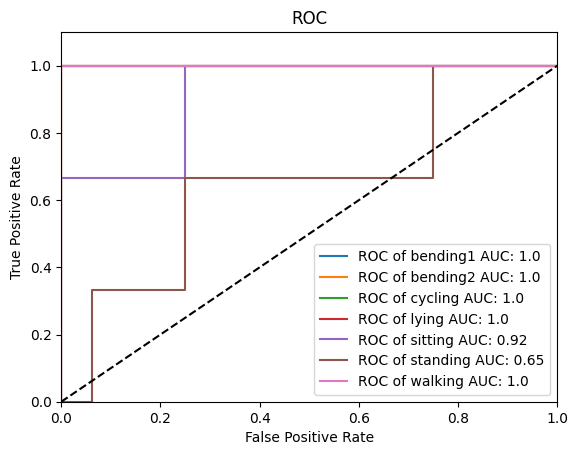

In [ ]:
from sklearn.metrics import auc

print('ROC FOR TESTING DATA ON MULTICLASS LOGISTIC REGRESSION:')
multiL1TestY = []
for i in range(0, len(MultiL1TestDataY)):
    row = []
    for j in range(0, 7):
        row.append(0)
    row[MultiL1TestDataY['Activity'][i]] = 1
    multiL1TestY.append(row)

multiL1TestY = pd.DataFrame(multiL1TestY, columns=directoryToRead)
predictedProbY = testPredictionProbability

fpr = {}
tpr = {}
multiclass_AUC = {}
for i in range(0, len(directoryToRead)):
    fpr[i], tpr[i], _ = roc_curve(multiL1TestY[directoryToRead[i]], predictedProbY[directoryToRead[i]])
    multiclass_AUC[i] = round(auc(fpr[i], tpr[i]), 2)

for i in range(0, 7):
    className = directoryToRead[i]
    label = 'ROC of ' + className + ' AUC: ' + str(multiclass_AUC[i])
    plt.plot(fpr[i], tpr[i], label=label)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

In [ ]:
MultiL1TestDataY = np.array(MultiL1TestDataY).flatten()

MultiL1ConfusionMatrix = confusion_matrix(MultiL1TestDataY, multiL1TestPredictions)
tableData = []
for i in range(0, len(MultiL1ConfusionMatrix)):
    row = np.array(MultiL1ConfusionMatrix[i], dtype='str')
    row = np.insert(row, 0, 'Actual ' + directoryToRead[i])
    tableData.append(row)

tableHeaders = []
tableHeaders.append('')
for i in range(0, len(directoryToRead)):
    tableHeaders.append('Predicted ' + directoryToRead[i])
print('CONFUSION MATRIX FOR MULTICLASS LOGISTIC REGRESSION:')
printDatainTable(tableHeaders, tableData)

CONFUSION MATRIX FOR MULTICLASS LOGISTIC REGRESSION:
+============+=============+===========+===========+==========+===========+===========+============+
|            | Predicted b | Predicted | Predicted | Predicte | Predicted | Predicted | Predicted  |
|            |   ending1   |  bending2 |  cycling  | d lying  |  sitting  |  standing |  walking   |
+============+=============+===========+===========+==========+===========+===========+============+
| Actual ben |      2      |     0     |     0     |    0     |     0     |     0     |     0      |
|   ding1    |             |           |           |          |           |           |            |
+------------+-------------+-----------+-----------+----------+-----------+-----------+------------+
| Actual ben |      0      |     2     |     0     |    0     |     0     |     0     |     0      |
|   ding2    |             |           |           |          |           |           |            |
+------------+-------------+----------

Multi-Class Classification using Gaussian Naive Bayes Classifier:

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

GaussianData = []
GaussianTrainData = {}
for L in range(1, 21):
    featuresToPlot = []
    GaussianTrainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])

            splitNum += 1

        idx = directoryToRead.index(activity)
        row.append(idx)
        GaussianTrainDataDF.append(row)

    featuresToPlot.append('Activity')
    GaussianTrainDataDF = pd.DataFrame(GaussianTrainDataDF, columns=featuresToPlot)

    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    accuracy = []
    for trainIdx, valIdx in stratifiedKFolds.split(GaussianTrainDataDF[featuresToPlot], GaussianTrainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(GaussianTrainDataDF[featuresToPlot].iloc[idx])
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)

        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(GaussianTrainDataDF[featuresToPlot].iloc[idx])
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)

        # Fit gaussian naive bayes classifier
        gaussianModel = GaussianNB()
        gaussianModel = gaussianModel.fit(trainX, trainY)

        # Cross-validation accuracy
        GaussianValidationAccuracy = gaussianModel.score(valX, valY)
        accuracy.append(GaussianValidationAccuracy)

    row = []
    row.append(L)
    row.append(round(np.mean(accuracy), 3))
    GaussianData.append(row)

    GaussianTrainData[L] = GaussianTrainDataDF

tableHeaders = ['L', 'Accuracy']
printDatainTable(tableHeaders, GaussianData)

+====+==========+
| L  | Accuracy |
+====+==========+
| 1  |   0.87   |
+----+----------+
| 2  |  0.769   |
+----+----------+
| 3  |  0.725   |
+----+----------+
| 4  |  0.724   |
+----+----------+
| 5  |  0.798   |
+----+----------+
| 6  |  0.725   |
+----+----------+
| 7  |  0.725   |
+----+----------+
| 8  |  0.725   |
+----+----------+
| 9  |  0.741   |
+----+----------+
| 10 |  0.726   |
+----+----------+
| 11 |  0.725   |
+----+----------+
| 12 |  0.755   |
+----+----------+
| 13 |  0.668   |
+----+----------+
| 14 |  0.741   |
+----+----------+
| 15 |  0.769   |
+----+----------+
| 16 |  0.741   |
+----+----------+
| 17 |  0.741   |
+----+----------+
| 18 |  0.741   |
+----+----------+
| 19 |  0.698   |
+----+----------+
| 20 |  0.698   |
+----+----------+


In [ ]:
GaussianMaxAccuracy = GaussianData[0][1]
GaussianBestL = GaussianData[0][0]
for i in range(0, len(GaussianData)):
    if GaussianData[i][1]>GaussianMaxAccuracy:
        GaussianMaxAccuracy = GaussianData[i][1]
        GaussianBestL = GaussianData[i][0]

print('------------------------------------------------------------------')
print('BEST L:', GaussianBestL)
print('------------------------------------------------------------------')
print('Best Cross-Validation Accuracy:', GaussianMaxAccuracy)
print('------------------------------------------------------------------')

------------------------------------------------------------------
BEST L: 1
------------------------------------------------------------------
Best Cross-Validation Accuracy: 0.87
------------------------------------------------------------------


In [ ]:
GaussianTrainDataDF = GaussianTrainData[GaussianBestL]
GaussianTrainDataY = pd.DataFrame(GaussianTrainDataDF['Activity'])
GaussianTrainDataX = GaussianTrainDataDF.drop('Activity', axis=1)

GaussianTrainDataY = np.array(GaussianTrainDataY).flatten()

finalGaussianModel = GaussianNB()
finalGaussianModel = finalGaussianModel.fit(GaussianTrainDataX, GaussianTrainDataY)

GaussianTrainAccuracy = finalGaussianModel.score(GaussianTrainDataX, GaussianTrainDataY)
GaussianTrainAccuracy = round(GaussianTrainAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA:')
print(GaussianTrainAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TRAINING DATA:')
print(round(1-GaussianTrainAccuracy, 3))
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
0.957
------------------------------------------------------------------
ERROR FOR TRAINING DATA:
0.043
------------------------------------------------------------------


In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
GaussianTestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, GaussianBestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*GaussianBestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])

        splitNum += 1

    idx = directoryToRead.index(activity)
    row.append(idx)
    GaussianTestDataDF.append(row)

featuresToPlot.append('Activity')
GaussianTestDataDF = pd.DataFrame(GaussianTestDataDF, columns=featuresToPlot)

GaussianTestDataY = pd.DataFrame(GaussianTestDataDF['Activity'])
GaussianTestDataX = GaussianTestDataDF.drop('Activity', axis=1)

GaussianTestAccuracy = finalGaussianModel.score(GaussianTestDataX, GaussianTestDataY)
GaussianTestAccuracy = round(GaussianTestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA:')
print(GaussianTestAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TESTING DATA:')
print(round(1-GaussianTestAccuracy, 3))
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TESTING DATA:
0.842
------------------------------------------------------------------
ERROR FOR TESTING DATA:
0.158
------------------------------------------------------------------


ROC and Confusion Matrix of Gaussian Naive Bayes:

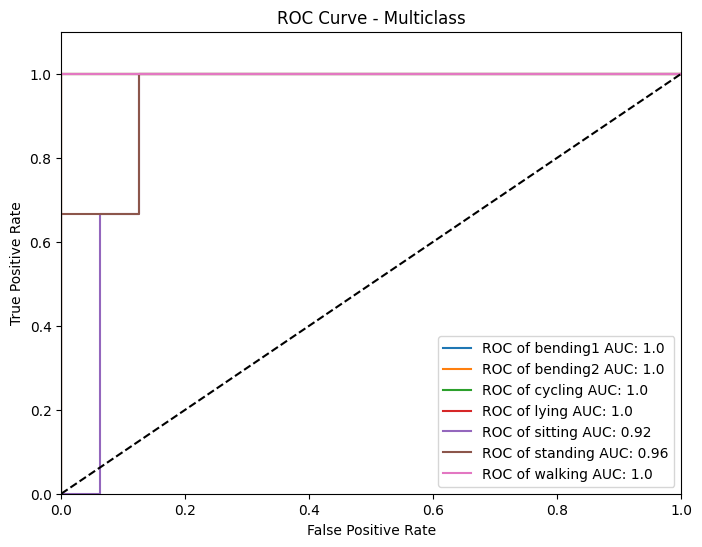

In [ ]:
gaussianplt, gaussianAUC = multiClassROC(finalGaussianModel, GaussianTrainDataY, GaussianTestDataX, GaussianTestDataY)
gaussianplt.show()

In [ ]:
GaussianPredictedY = finalGaussianModel.predict(GaussianTestDataX)
GaussianTestDataY = np.array(GaussianTestDataY).flatten()
gaussianConfusionMatrix = confusion_matrix(GaussianTestDataY, GaussianPredictedY)
tableData = []
for i in range(0, len(gaussianConfusionMatrix)):
    row = np.array(gaussianConfusionMatrix[i], dtype='str')
    row = np.insert(row, 0, 'Actual ' + directoryToRead[i])
    tableData.append(row)

tableHeaders = []
tableHeaders.append('')
for i in range(0, len(directoryToRead)):
    tableHeaders.append('Predicted ' + directoryToRead[i])
print('CONFUSION MATRIX FOR GAUSSIAN NAIVE BAYES CLASSIFIER:')
printDatainTable(tableHeaders, tableData)

CONFUSION MATRIX FOR GAUSSIAN NAIVE BAYES CLASSIFIER:
+============+=============+===========+===========+==========+===========+===========+============+
|            | Predicted b | Predicted | Predicted | Predicte | Predicted | Predicted | Predicted  |
|            |   ending1   |  bending2 |  cycling  | d lying  |  sitting  |  standing |  walking   |
+============+=============+===========+===========+==========+===========+===========+============+
| Actual ben |      2      |     0     |     0     |    0     |     0     |     0     |     0      |
|   ding1    |             |           |           |          |           |           |            |
+------------+-------------+-----------+-----------+----------+-----------+-----------+------------+
| Actual ben |      0      |     1     |     0     |    0     |     1     |     0     |     0      |
|   ding2    |             |           |           |          |           |           |            |
+------------+-------------+---------

Multi-Class Classification using Multinomial Naive Bayes Classifier:

In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

MultinomialData = []
MultinomialTrainData = {}
for L in range(1, 21):
    featuresToPlot = []
    MultinomialTrainDataDF = []

    for k,v in trainData.items():
        activity = k.split('/')[1]
        splits = np.array_split(v, L)
        row = []
        splitNum = 1
        for split in splits:
            stats = getStatistics(split)
            for feature in selectedFeatures:
                dataFeaturesStats = stats[feature]
                for i in range(0, 6):
                    if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*L:
                        featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                    row.append(dataFeaturesStats[i])

            splitNum += 1

        idx = directoryToRead.index(activity)
        row.append(idx)
        MultinomialTrainDataDF.append(row)

    featuresToPlot.append('Activity')
    MultinomialTrainDataDF = pd.DataFrame(MultinomialTrainDataDF, columns=featuresToPlot)

    stratifiedKFolds = StratifiedKFold(n_splits=5, shuffle=False)
    accuracy = []
    for trainIdx, valIdx in stratifiedKFolds.split(MultinomialTrainDataDF[featuresToPlot], MultinomialTrainDataDF['Activity']):
        # Get training data
        trainXY = []
        for idx in trainIdx:
            trainXY.append(MultinomialTrainDataDF[featuresToPlot].iloc[idx])
        trainXY = pd.DataFrame(trainXY)
        trainY = trainXY['Activity']
        trainX = trainXY.drop('Activity', axis=1)

        # Get cross-validation data
        valXY = []
        for idx in valIdx:
            valXY.append(MultinomialTrainDataDF[featuresToPlot].iloc[idx])
        valXY = pd.DataFrame(valXY)
        valY = valXY['Activity']
        valX = valXY.drop('Activity', axis=1)

        # Fit multinomial naive bayes classifier
        MultinomialModel = MultinomialNB()
        MultinomialModel = MultinomialModel.fit(trainX, trainY)

        # Cross-validation accuracy
        MultinomialValidationAccuracy = MultinomialModel.score(valX, valY)
        accuracy.append(MultinomialValidationAccuracy)

    row = []
    row.append(L)
    row.append(round(np.mean(accuracy), 3))
    MultinomialData.append(row)

    MultinomialTrainData[L] = MultinomialTrainDataDF

tableHeaders = ['L', 'Accuracy']
printDatainTable(tableHeaders, MultinomialData)

+====+==========+
| L  | Accuracy |
+====+==========+
| 1  |  0.797   |
+----+----------+
| 2  |  0.825   |
+----+----------+
| 3  |  0.825   |
+----+----------+
| 4  |  0.811   |
+----+----------+
| 5  |  0.782   |
+----+----------+
| 6  |  0.782   |
+----+----------+
| 7  |  0.797   |
+----+----------+
| 8  |  0.782   |
+----+----------+
| 9  |  0.768   |
+----+----------+
| 10 |  0.782   |
+----+----------+
| 11 |  0.768   |
+----+----------+
| 12 |  0.754   |
+----+----------+
| 13 |  0.768   |
+----+----------+
| 14 |  0.754   |
+----+----------+
| 15 |  0.768   |
+----+----------+
| 16 |  0.768   |
+----+----------+
| 17 |  0.768   |
+----+----------+
| 18 |  0.768   |
+----+----------+
| 19 |   0.74   |
+----+----------+
| 20 |  0.754   |
+----+----------+


In [ ]:
MultinomialMaxAccuracy = MultinomialData[0][1]
MultinomialBestL = MultinomialData[0][0]
for i in range(0, len(MultinomialData)):
    if MultinomialData[i][1]>MultinomialMaxAccuracy:
        MultinomialMaxAccuracy = MultinomialData[i][1]
        MultinomialBestL = MultinomialData[i][0]

print('------------------------------------------------------------------')
print('BEST L:', MultinomialBestL)
print('------------------------------------------------------------------')
print('Best Cross-Validation Accuracy:', MultinomialMaxAccuracy)
print('------------------------------------------------------------------')

------------------------------------------------------------------
BEST L: 2
------------------------------------------------------------------
Best Cross-Validation Accuracy: 0.825
------------------------------------------------------------------


In [ ]:
MultinomialTrainDataDF = MultinomialTrainData[MultinomialBestL]
MultinomialTrainDataY = pd.DataFrame(MultinomialTrainDataDF['Activity'])
MultinomialTrainDataX = MultinomialTrainDataDF.drop('Activity', axis=1)

MultinomialTrainDataY = np.array(MultinomialTrainDataY).flatten()

finalMultinomialModel = MultinomialNB()
finalMultinomialModel = finalMultinomialModel.fit(MultinomialTrainDataX, MultinomialTrainDataY)

MultinomialTrainAccuracy = finalMultinomialModel.score(MultinomialTrainDataX, MultinomialTrainDataY)
MultinomialTrainAccuracy = round(MultinomialTrainAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TRAINING DATA:')
print(MultinomialTrainAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TRAINING DATA:')
print(round(1-MultinomialTrainAccuracy, 3))
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TRAINING DATA:
0.913
------------------------------------------------------------------
ERROR FOR TRAINING DATA:
0.087
------------------------------------------------------------------


In [ ]:
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]
featuresToPlot = []
MultinomialTestDataDF = []
for k,v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, MultinomialBestL)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(0, 6):
                if len(featuresToPlot)<len(selectedFeatures)*len(featuresToTake)*MultinomialBestL:
                    featuresToPlot.append(feature + '_Split' + str(splitNum) + '_' + columnNames[i])
                row.append(dataFeaturesStats[i])

        splitNum += 1

    idx = directoryToRead.index(activity)
    row.append(idx)
    MultinomialTestDataDF.append(row)

featuresToPlot.append('Activity')
MultinomialTestDataDF = pd.DataFrame(MultinomialTestDataDF, columns=featuresToPlot)

MultinomialTestDataY = pd.DataFrame(MultinomialTestDataDF['Activity'])
MultinomialTestDataX = MultinomialTestDataDF.drop('Activity', axis=1)

MultinomialTestAccuracy = finalMultinomialModel.score(MultinomialTestDataX, MultinomialTestDataY)
MultinomialTestAccuracy = round(MultinomialTestAccuracy, 3)
print('------------------------------------------------------------------')
print('ACCURACY FOR TESTING DATA:')
print(MultinomialTestAccuracy)
print('------------------------------------------------------------------')
print('ERROR FOR TESTING DATA:')
print(round(1-MultinomialTestAccuracy, 3))
print('------------------------------------------------------------------')

------------------------------------------------------------------
ACCURACY FOR TESTING DATA:
0.842
------------------------------------------------------------------
ERROR FOR TESTING DATA:
0.158
------------------------------------------------------------------


ROC and Confusion Matrix of Multinomial Naive Bayes:

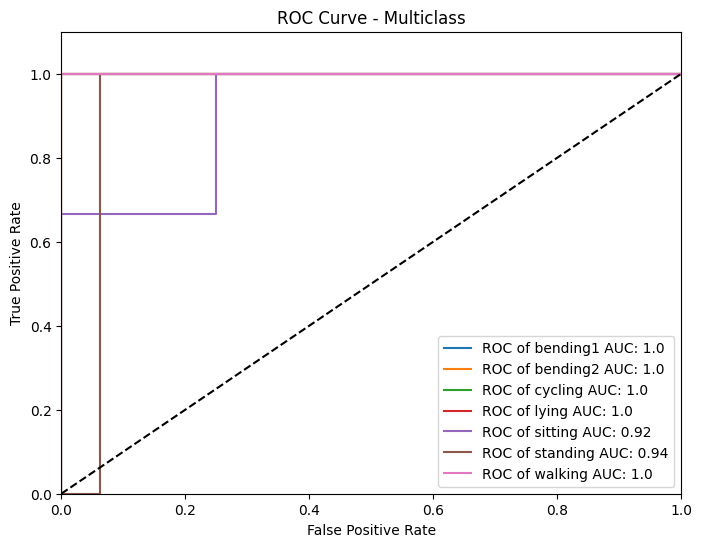

In [ ]:
multinomialplt, multinomialAUC = multiClassROC(finalMultinomialModel, MultinomialTrainDataY, MultinomialTestDataX, MultinomialTestDataY)
multinomialplt.show()

In [ ]:
MultinomialPredictedY = finalMultinomialModel.predict(MultinomialTestDataX)
MultinomialTestDataY = np.array(MultinomialTestDataY).flatten()
MultinomialConfusionMatrix = confusion_matrix(MultinomialTestDataY, MultinomialPredictedY)
tableData = []
for i in range(0, len(MultinomialConfusionMatrix)):
    row = np.array(MultinomialConfusionMatrix[i], dtype='str')
    row = np.insert(row, 0, 'Actual ' + directoryToRead[i])
    tableData.append(row)

tableHeaders = []
tableHeaders.append('')
for i in range(0, len(directoryToRead)):
    tableHeaders.append('Predicted ' + directoryToRead[i])
print('CONFUSION MATRIX FOR MULTINOMIAL NAIVE BAYES CLASSIFIER:')
printDatainTable(tableHeaders, tableData)

CONFUSION MATRIX FOR MULTINOMIAL NAIVE BAYES CLASSIFIER:
+============+=============+===========+===========+==========+===========+===========+============+
|            | Predicted b | Predicted | Predicted | Predicte | Predicted | Predicted | Predicted  |
|            |   ending1   |  bending2 |  cycling  | d lying  |  sitting  |  standing |  walking   |
+============+=============+===========+===========+==========+===========+===========+============+
| Actual ben |      2      |     0     |     0     |    0     |     0     |     0     |     0      |
|   ding1    |             |           |           |          |           |           |            |
+------------+-------------+-----------+-----------+----------+-----------+-----------+------------+
| Actual ben |      1      |     1     |     0     |    0     |     0     |     0     |     0      |
|   ding2    |             |           |           |          |           |           |            |
+------------+-------------+------

Comparison between Multiclass Logistic Regression, Gaussian Naive Bayes and Multinomial Naive Bayes Classifier:

In [ ]:
tableHeaders = ['Parameter', 'Multiclass Logistic Regression', 'Gaussian Naive Bayes', 'Multinomial Naive Bayes']
tableData = []
row1 = []
row1.append('Training Accuracy')
row1.append(MultiL1TrainAccuracy)
row1.append(GaussianTrainAccuracy)
row1.append(MultinomialTrainAccuracy)
tableData.append(row1)

row2 = []
row2.append('Testing Accuracy')
row2.append(MultiL1TestAccuracy)
row2.append(GaussianTestAccuracy)
row2.append(MultinomialTestAccuracy)
tableData.append(row2)

for i in range(0, 7):
    row = []
    row.append(directoryToRead[i] + ' AUC')
    row.append(multiclass_AUC[i])
    row.append(gaussianAUC[i])
    row.append(multinomialAUC[i])
    tableData.append(row)

printDatainTable(tableHeaders, tableData)

+===================+===============================+======================+=======================+
|     Parameter     | Multiclass Logistic Regressio | Gaussian Naive Bayes | Multinomial Naive Bay |
|                   |               n               |                      |          es           |
+===================+===============================+======================+=======================+
| Training Accuracy |             0.971             |        0.957         |         0.913         |
+-------------------+-------------------------------+----------------------+-----------------------+
| Testing Accuracy  |             0.895             |        0.842         |         0.842         |
+-------------------+-------------------------------+----------------------+-----------------------+
|   bending1 AUC    |              1.0              |         1.0          |          1.0          |
+-------------------+-------------------------------+----------------------+---------------

PCA - Naive Bayes

✅ Training Accuracy: 0.957
🔹 Confusion Matrix:
          bending1  bending2  cycling  lying  sitting  standing  walking
bending1         5         0        0      0        0         0        0
bending2         0         3        0      1        0         0        0
cycling          0         0       12      0        0         0        0
lying            0         0        0     12        0         0        0
sitting          0         0        0      0       12         0        0
standing         0         0        0      0        2        10        0
walking          0         0        0      0        0         0       12


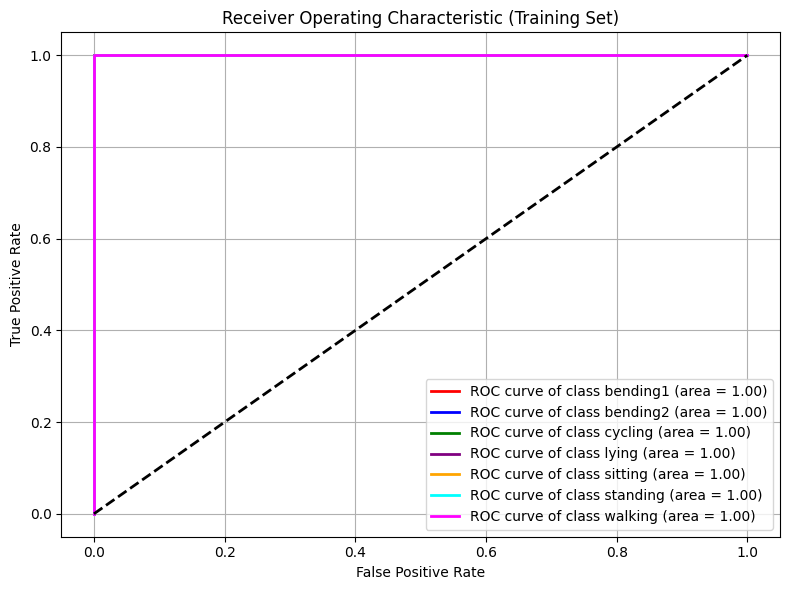

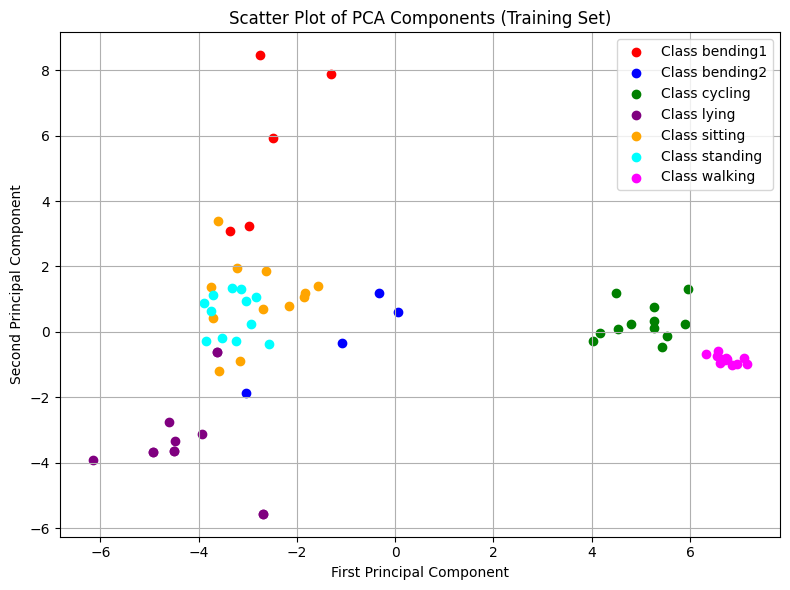


✅ Test Accuracy: 0.842
🔹 Test Confusion Matrix:
          bending1  bending2  cycling  lying  sitting  standing  walking
bending1         2         0        0      0        0         0        0
bending2         0         1        0      0        1         0        0
cycling          0         0        3      0        0         0        0
lying            0         0        0      3        0         0        0
sitting          0         0        0      0        2         1        0
standing         0         0        0      0        1         2        0
walking          0         0        0      0        0         0        3


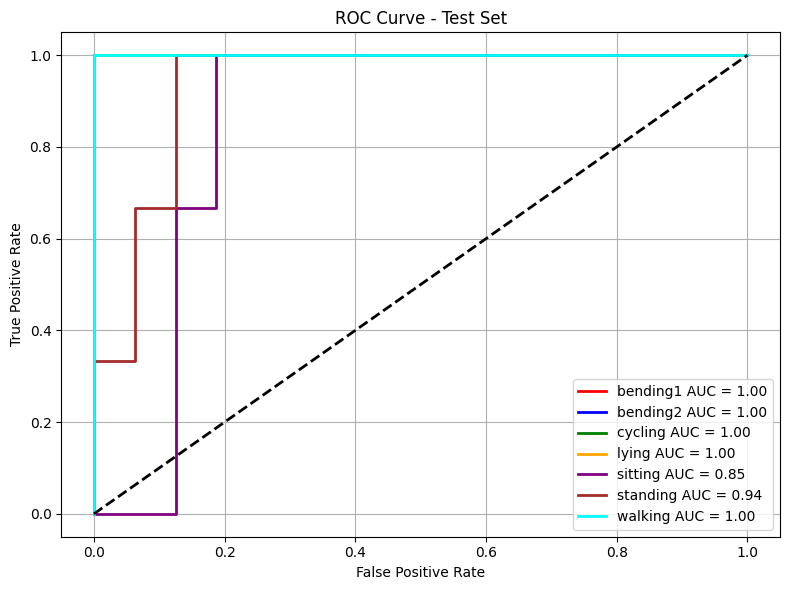

In [ ]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---- PARAMETERS ----
L = 2
p = 10
selectedFeatures = ['Mean', 'Median', 'Std']
featuresToTake = [1, 2, 3, 4, 5, 6]

# ---- STEP 1: Extract features from trainData using L ----
trainDataDF = []
featuresToPlot = []

for k, v in trainData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, L)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(6):
                if len(featuresToPlot) < len(selectedFeatures) * len(featuresToTake) * L:
                    featuresToPlot.append(f"{feature}_Split{splitNum}_{columnNames[i]}")
                row.append(dataFeaturesStats[i])
        splitNum += 1

    row.append(activity)
    trainDataDF.append(row)

featuresToPlot.append('Activity')
trainDataDF = pd.DataFrame(trainDataDF, columns=featuresToPlot)

# --- Step 2: Prepare test data
testDataDF = []

for k, v in testData.items():
    activity = k.split('/')[1]
    splits = np.array_split(v, L)
    row = []
    splitNum = 1
    for split in splits:
        stats = getStatistics(split)
        for feature in selectedFeatures:
            dataFeaturesStats = stats[feature]
            for i in range(6):
                row.append(dataFeaturesStats[i])
        splitNum += 1
    row.append(activity)
    testDataDF.append(row)

testDataDF = pd.DataFrame(testDataDF, columns=featuresToPlot)


# --- Step 3: Train/Test split ---
X_train = trainDataDF.drop('Activity', axis=1)
y_train = trainDataDF['Activity']
class_labels = y_train.unique()

X_test = testDataDF.drop('Activity', axis=1)
y_test = testDataDF['Activity']
class_labels = y_test.unique()

# --- Step 4: Standardize + PCA ---
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# PCA
pca = PCA(n_components=p)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Train Naive Bayes
nb = GaussianNB()
nb.fit(X_train_pca, y_train)
y_train_pred = nb.predict(X_train_pca)

# Accuracy + Confusion Matrix - train
accuracy = accuracy_score(y_train, y_train_pred)
conf_matrix = confusion_matrix(y_train, y_train_pred, labels=class_labels)
print(f"✅ Training Accuracy: {round(accuracy, 3)}")
print("🔹 Confusion Matrix:")
print(pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels))

# ROC Curve - train
y_train_bin = label_binarize(y_train, classes=class_labels)
y_train_prob = nb.predict_proba(X_train_pca)
n_classes = y_train_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve of class {class_labels[i]} (area = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Receiver Operating Characteristic (Training Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# --- PCA Scatter Plot of First 2 Components ---
plt.figure(figsize=(8, 6))
for label, color in zip(class_labels, colors):
    idx = (y == label)
    plt.scatter(X_train_pca[idx, 0], X_train_pca[idx, 1], label=f"Class {label}", color=color)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Scatter Plot of PCA Components (Training Set)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#test data -----------------------------------------------------------------------

# --- Evaluate on test data ---
y_test_pred = nb.predict(X_test_pca)
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_train))

print(f"\n✅ Test Accuracy: {round(test_accuracy, 3)}")
print("🔹 Test Confusion Matrix:")
print(pd.DataFrame(conf_matrix_test, index=np.unique(y_train), columns=np.unique(y_train)))

# --- ROC Curve for Test Set ---
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
y_test_prob = nb.predict_proba(X_test_pca)
n_classes = y_test_bin.shape[1]

fpr_test, tpr_test, roc_auc_test = {}, {}, {}
for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

plt.figure(figsize=(8, 6))
colors = cycle(['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2,
             label=f"{np.unique(y_train)[i]} AUC = {roc_auc_test[i]:.2f}")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('ROC Curve - Test Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

PCA with Naive Bayes: Test accuracy: 0.8421 Using PCA can reduce dimensionality. Conclusion: L1-Penalized Logistic Regression is the best model in terms of cross-validation performance. Gaussian Naive Bayes is simpler to implement and performs well but lower cross-validation score. The test accuracies for all models are similar, but the logistic regression model demonstrated better performance during cross-validation. If we give importance to model performance based on cross-validation, L1-Penalized Logistic Regression can be selected. If ease of implementation(less complex) is more important, Gaussian Naive Bayes is the best model.